# Neural Ordinary Differential Equations

Preamble: Run the cells below to import the necessary Python packages

+ This notebook is modified from notebooks originally developed and used in [Pankaj Mehta's ML for physics course](http://physics.bu.edu/~pankajm/PY580.html) at Boston University. Please check out those notebooks and associated textbooks for additional details and exercises.

In [ ]:
## Preamble / required packages
import numpy as np
np.random.seed(0)

# Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
from IPython.display import Image, display
%matplotlib inline

import warnings
# Comment this out to activate warnings
warnings.filterwarnings('ignore')


In [6]:
import jax
import jax.numpy as jnp
from jax import lax
import numpy as np
import matplotlib.pyplot as plt

# Define the Kuramoto model
def kuramoto(theta, t, omega, K):
    N = theta.shape[0]
    dtheta_dt = omega + jnp.sum(K * jnp.sin(theta[:, None] - theta[None, :]), axis=1)
    return dtheta_dt

# Implement the Runge-Kutta 4th order integration using JAX's functional loops
def runge_kutta_step(f, theta, t, dt, args):
    k1 = f(theta, t, *args)
    k2 = f(theta + dt/2 * k1, t + dt/2, *args)
    k3 = f(theta + dt/2 * k2, t + dt/2, *args)
    k4 = f(theta + dt * k3, t + dt, *args)
    theta_next = theta + dt/6 * (k1 + 2*k2 + 2*k3 + k4)
    return theta_next

def runge_kutta_integration(f, theta0, t, args):
    dt = t[1] - t[0]
    def body_fun(theta, t_i):
        theta_next = runge_kutta_step(f, theta, t_i, dt, args)
        return theta_next, theta_next
    thetas = lax.scan(body_fun, theta0, t[:-1])[1]
    thetas = jnp.concatenate([theta0[None,:], thetas], axis=0)
    return thetas

# Define the order parameter
def order_parameter(theta):
    return jnp.abs(jnp.mean(jnp.exp(1j * theta)))

# Define the local order parameter for chimera detection
def local_order_parameter(theta, idx_group):
    return jnp.abs(jnp.mean(jnp.exp(1j * theta[idx_group])))

# Generate initial conditions and natural frequencies
N = 50  # Number of oscillators
t = jnp.linspace(0.0, 50.0, 1000)  # Time grid
theta0 = jnp.linspace(0, 2 * jnp.pi, N) + 0.1 * jnp.random.randn(N)  # Initial phases
omega = jnp.zeros(N)  # Identical natural frequencies

# Partition the oscillators into two groups
group_size = N // 2
idx_group1 = jnp.arange(group_size)
idx_group2 = jnp.arange(group_size, N)

# Initialize the coupling matrix K
# We will train K to induce a chimera state
K = jnp.zeros((N, N)) + 0.1  # Initial coupling strengths

# Define the loss function
def loss_fn(K_flat):
    K = K_flat.reshape(N, N)
    # Ensure K is symmetric and zero diagonal (no self-coupling)
    K = (K + K.T) / 2
    K = K - jnp.diag(jnp.diag(K))
    thetas = runge_kutta_integration(kuramoto, theta0, t, (omega, K))
    
    # Compute local order parameters
    r1 = jax.vmap(lambda theta: local_order_parameter(theta, idx_group1))(thetas)
    r2 = jax.vmap(lambda theta: local_order_parameter(theta, idx_group2))(thetas)
    
    # Loss function aims to maximize the difference between r1 and r2
    # One group synchronized (r ~ 1), the other desynchronized (r ~ 0)
    loss = -jnp.mean((r1 - r2)**2)
    return loss

# Compile the loss and gradient functions
loss_fn = jax.jit(loss_fn)
grad_loss_fn = jax.jit(jax.grad(loss_fn))

# Initialize the coupling matrix parameters
K_flat = K.flatten()
learning_rate = 0.1

# Training loop
for epoch in range(100):
    loss = loss_fn(K_flat)
    grad_loss = grad_loss_fn(K_flat)
    K_flat = K_flat - learning_rate * grad_loss
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.6f}")

# Reshape K to matrix form and ensure symmetry and zero diagonal
K = K_flat.reshape(N, N)
K = (K + K.T) / 2
K = K - jnp.diag(jnp.diag(K))

# Simulate with the trained coupling matrix
thetas = runge_kutta_integration(kuramoto, theta0, t, (omega, K))

# Compute local order


AttributeError: module 'jax.numpy' has no attribute 'random'

Epoch 0, Loss: 20.077463, F: 5.004202
Epoch 10, Loss: 19.854036, F: 5.052192
Epoch 20, Loss: 19.508900, F: 5.111727
Epoch 30, Loss: 19.012432, F: 5.182972
Epoch 40, Loss: 18.350771, F: 5.264993
Epoch 50, Loss: 17.571400, F: 5.353467
Epoch 60, Loss: 16.846825, F: 5.437777
Epoch 70, Loss: 16.356039, F: 5.506146
Epoch 80, Loss: 16.107138, F: 5.554224
Epoch 90, Loss: 16.003963, F: 5.584910
Epoch 100, Loss: 15.966246, F: 5.603364
Epoch 110, Loss: 15.953469, F: 5.614069
Epoch 120, Loss: 15.949333, F: 5.620149
Epoch 130, Loss: 15.948029, F: 5.623561
Epoch 140, Loss: 15.947621, F: 5.625463
Epoch 150, Loss: 15.947495, F: 5.626518
Epoch 160, Loss: 15.947453, F: 5.627103
Epoch 170, Loss: 15.947445, F: 5.627427
Epoch 180, Loss: 15.947440, F: 5.627606
Epoch 190, Loss: 15.947436, F: 5.627706
Epoch 200, Loss: 15.947438, F: 5.627760
Epoch 210, Loss: 15.947439, F: 5.627790
Epoch 220, Loss: 15.947437, F: 5.627808
Epoch 230, Loss: 15.947442, F: 5.627816
Epoch 240, Loss: 15.947442, F: 5.627821
Epoch 250, 

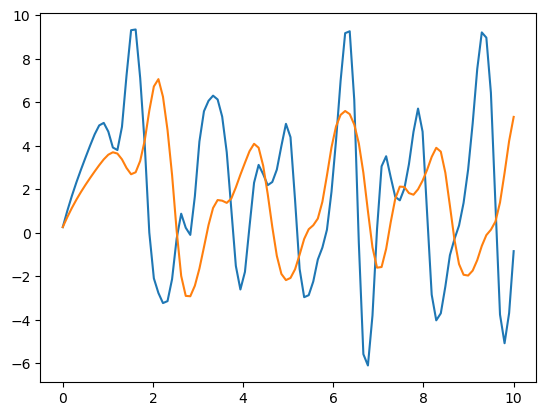

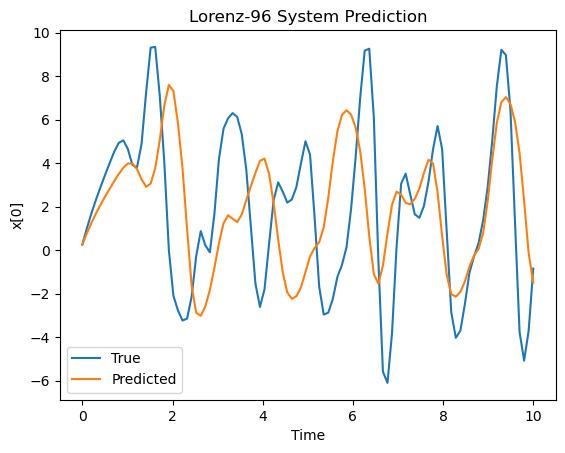

In [5]:
import jax
import jax.numpy as jnp
from jax import lax
import numpy as np
import matplotlib.pyplot as plt

# Define the Lorenz-96 system
def lorenz96(x, t, F):
    N = x.shape[0]
    dxdt = (x[(jnp.arange(N)+1)%N] - x[(jnp.arange(N)-2)%N]) * x[(jnp.arange(N)-1)%N] - x + F
    return dxdt

# Implement the Runge-Kutta 4th order integration using JAX's functional loops
def runge_kutta_step(f, x, t, dt, args):
    k1 = f(x, t, *args)
    k2 = f(x + dt/2 * k1, t + dt/2, *args)
    k3 = f(x + dt/2 * k2, t + dt/2, *args)
    k4 = f(x + dt * k3, t + dt, *args)
    x_next = x + dt/6 * (k1 + 2*k2 + 2*k3 + k4)
    return x_next

def runge_kutta_integration(f, x0, t, args):
    dt = t[1] - t[0]
    def body_fun(x, t_i):
        x_next = runge_kutta_step(f, x, t_i, dt, args)
        return x_next, x_next
    xs = lax.scan(body_fun, x0, t[:-1])[1]
    xs = jnp.concatenate([x0[None,:], xs], axis=0)
    return xs

# Generate synthetic data using known parameters
from scipy.integrate import odeint as scipy_odeint

N = 5
F_true = 8.0  # True forcing parameter
t = np.linspace(0.0, 10.0, 100)  # Time grid

# Initial conditions
x0 = np.random.rand(N)

def lorenz96_scipy(x, t, F):
    N = x.shape[0]
    dxdt = (x[(np.arange(N)+1)%N] - x[(np.arange(N)-2)%N]) * x[(np.arange(N)-1)%N] - x + F
    return dxdt

x_true = scipy_odeint(lorenz96_scipy, x0, t, args=(F_true,))

# Convert data to JAX arrays
x_true = jnp.array(x_true)
x0 = jnp.array(x0)
t = jnp.array(t)

# Define the prediction function using the integrator
def predict_lorenz96(F):
    x_pred = runge_kutta_integration(lorenz96, x0, t, (F,))
    return x_pred

# Define the loss function
def loss_fn(F):
    x_pred = predict_lorenz96(F)
    loss = jnp.mean((x_pred - x_true)**2)
    return loss

# Compile the loss and gradient functions
loss_fn = jax.jit(loss_fn)
grad_loss_fn = jax.jit(jax.grad(loss_fn))



# Initialize the parameter to be trained
F = jnp.array(5.0)  # Initial guess for F
learning_rate = 0.001

x_pred = predict_lorenz96(F)
plt.figure()
plt.plot(t, x_true[:, 0], label='True')
plt.plot(t, x_pred[:, 0], label='Predicted')

# Training loop
for epoch in range(2000):
    loss = loss_fn(F)
    grad_loss = grad_loss_fn(F)
    F = F - learning_rate * grad_loss
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.6f}, F: {F:.6f}")

# Plotting the results
plt.figure()
x_pred = predict_lorenz96(F)
plt.plot(t, x_true[:, 0], label='True')
plt.plot(t, x_pred[:, 0], label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('x[0]')
plt.title('Lorenz-96 System Prediction')
plt.show()


## Steering a trajectory

In [71]:

from scipy.stats import multivariate_normal
def make_gmm(orbit_points, sigma_squared=1.0):
    """Create a Gaussian Mixture Model from orbit points."""
    N = orbit_points[0].shape[0]  # Dimensionality of the state space
    cov_matrix = sigma_squared * np.eye(N)
    
    def gmm(x):
        return np.mean(
            [multivariate_normal.pdf(x, mean=x_t, cov=cov_matrix) for x_t in orbit_points]
        )
    def gmm(x):
        x = np.atleast_2d(x)
        diff = x[:, np.newaxis, :] - orbit_points[np.newaxis, :, :]
        maha_dist = np.einsum('ijk,kl,ijl->ij', diff, np.linalg.inv(cov_matrix), diff)
        pdf = np.exp(-0.5 * maha_dist) / np.sqrt((2 * np.pi)**x.shape[1] * np.linalg.det(cov_matrix))
        return np.mean(pdf, axis=1)
    
    return gmm

def estimate_kl_divergence(observed_orbit, generated_orbit, n_samples=1000, sigma_squared=1.0):
    """Estimate KL divergence between observed and generated orbit GMMs."""
    p_hat = make_gmm(observed_orbit, sigma_squared)
    q_hat = make_gmm(generated_orbit, sigma_squared)
    
    # Generate Monte Carlo samples from p_hat
    T, N = observed_orbit.shape
    cov_matrix = sigma_squared * np.eye(N)
    samples = np.array([multivariate_normal.rvs(mean=x_t, cov=cov_matrix) for x_t in observed_orbit])
    
    # Randomly select n_samples from the generated samples
    selected_samples = samples[np.random.choice(T, n_samples, replace=True)]
    
    # Compute KL divergence estimate
    log_ratios = np.log(p_hat(selected_samples) / q_hat(selected_samples))
    kl_estimate = np.mean(log_ratios)
    
    return kl_estimate

# from sklearn.mixture import GaussianMixture

# def estimate_kl_divergence2(observed_orbit, generated_orbit, n_samples=100):
#     # Fit GMMs to the observed and generated orbits
#     gmm_observed = GaussianMixture(n_components=30, covariance_type='full').fit(observed_orbit)
#     gmm_generated = GaussianMixture(n_components=30, covariance_type='full').fit(generated_orbit)
    
#     # Monte Carlo sampling
#     samples = gmm_observed.sample(n_samples)[0]
    
#     # Estimate the densities
#     p_hat = np.exp(gmm_observed.score_samples(samples))
#     q_hat = np.exp(gmm_generated.score_samples(samples))
    
#     # Estimate the KL divergence
#     kl_divergence = np.mean(np.log(p_hat / q_hat))
    
#     return kl_divergence

# Example usage
np.random.seed(42)

# Generate example orbits (replace with actual orbit data)
T, N = 100, 5  # 100 time steps, 5-dimensional state space
observed_orbit = np.random.randn(T, N)
generated_orbit = np.random.randn(T, N)

kl_div = estimate_kl_divergence(observed_orbit, generated_orbit)
print(f"Estimated KL divergence: {kl_div}")


Estimated KL divergence: -0.004682440802005368


In [68]:
from dysts.flows import Lorenz, Rossler

eq1 = Lorenz()
eq2 = Rossler()

traj1 = eq1.make_trajectory(2000, standardize=True)
traj2 = eq2.make_trajectory(1000, standardize=True)

traj1a, traj1b = np.split(traj1, 2)

In [72]:
%timeit estimate_kl_divergence(traj1a, traj1b)

155 ms ± 1.63 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [69]:
np.random.seed(0)
estimate_kl_divergence(traj1a, traj1b)

0.007871260091662696

0.015091146359590218

In [42]:
all_estimates = []
for _ in range(1000):
    traj1, traj2 = np.random.randn(1000, 3), np.random.randn(1000, 3)
    k1 = estimate_kl_divergence(traj1, traj2)
    k2 = estimate_kl_divergence2(traj1, traj2)
    all_estimates.append((k1, k2))
all_estimates = np.array(all_estimates)


TypeError: BaseMixture.fit() got an unexpected keyword argument 'max_iter'

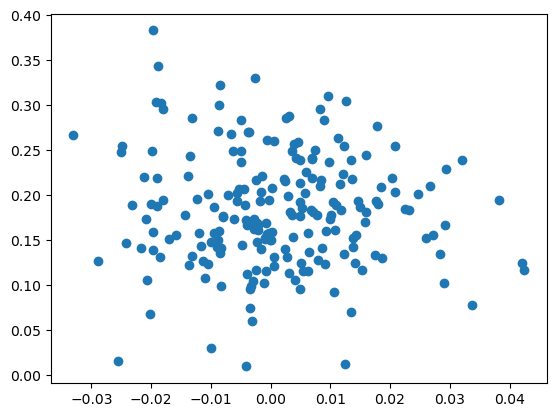

In [40]:
all_estimates = np.array(all_estimates)
plt.scatter(all_estimates[:, 0], all_estimates[:, 1])

In [27]:
print(estimate_kl_divergence2(traj1a, traj2))

inf


# Supervised learning

+ Given an input $X$, construct a function that assigns it a label $\hat{y}$. 

+ **Regression:** $\hat{y}$ is a continuous variable. For example, given a picture of a person, predict their age. In physics, a common example is to predict the energy of a particle given its momentum, or forecast the next step in a time series.

+ **Classification:** $\hat{y}$ is a discrete variable. For example, given a picture of an animal, predict whether it is a cat or a dog. In physics, a common example is to predict whether a phase is ordered or disordered, or to detect whether a signal point is a background, signal, or anomaly.

The function $\hat{y} = f_\theta(X)$ is learned from many instances of labelled data comprising $X \in \mathbb{N_\text{data} \times N_\text{features}}$ and known $y \in \mathbb{N_\text{data}}$ pairs. The "weights" or parameters $\theta$ are adjusted during *training*.


<img src="../resources/supervised_learning.gif" alt="supervised_learning" style="width: 750px;"/>


*Image from [source](https://github.com/ReiCHU31/Cat-Dog-Classification-Flask-App)*

## Supervised learning as inferring a generator

+ We can see supervised learning as the process of learning a *generator* for a dataset: given a set of points, can we approximate the underlying process that produced those points?
+ + Forecasting: given some past values, predict future values
+ + Regression: Given a known generator with unknonw parameters (like a quadratic Hamiltonian with unknown amplitudes), infer those amplitudes
+ + Classification (most famous example in ML): Given examples of labelled images, states, etc, predict the class of unlabelled data. We can think of the learned decision boundary as defining a generator of new examples belonging to that class (see conditional GANs, etc)

# One-dimensional cellular automata

+ We've seen this code before; we implemented a "compiled" cellular automaton function in the genetic algorithms module

In [ ]:
class CellularAutomaton:
    """
    A base class for cellular automata. Subclasses must implement the step method.

    Parameters
        n (int): The number of cells in the system
        n_states (int): The number of states in the system
        random_state (None or int): The seed for the random number generator. If None,
            the random number generator is not seeded.
        initial_state (None or array): The initial state of the system. If None, a 
            random initial state is used.
        
    """
    def __init__(self, n, n_states, random_state=None, initial_state=None):
        self.n_states = n_states
        self.n = n
        self.random_state = random_state

        np.random.seed(random_state)

        ## The universe is a 2D array of integers
        if initial_state is None:
            self.initial_state = np.random.choice(self.n_states, size=(self.n, self.n))
        else:
            self.initial_state = initial_state
        self.state = self.initial_state

        self.history = [self.state]

    def next_state(self):
        """
        Output the next state of the entire board
        """
        return NotImplementedError

    def simulate(self, n_steps):
        """
        Iterate the dynamics for n_steps, and return the results as an array
        """
        for i in range(n_steps):
            self.state = self.next_state()
            self.history.append(self.state.copy())
        return self.state
    

from scipy.signal import convolve2d

class ProgrammaticCA(CellularAutomaton):

    def __init__(self, n, ruleset,  **kwargs):
        k = np.unique(ruleset).size
        super().__init__(n, k, **kwargs)
        self.ruleset = ruleset

        ## A special convolutional kernel for converting a binary neighborhood 
        ## to an integer
        self.powers = np.reshape(2 ** np.arange(9), (3, 3))

    def next_state(self):

        # Compute the next state
        next_state = np.zeros_like(self.state)
        
        # convolve with periodic boundary conditions
        rule_indices = convolve2d(self.state, self.powers, mode='same', boundary='wrap')

        ## look up the rule for each cell
        next_state = self.ruleset[rule_indices.astype(int)]

        return next_state

In [ ]:
class CellularAutomaton:
    """A base class for one-dimensional cellular automata"""

    def __init__(self, n):
        self.n = n
        self.powers = 2 ** np.arange(3)

from scipy.signal import convolve1d
class Rule30Automaton(CellularAutomaton):

    def __init__(self, n,  **kwargs):

        ruleset = 
        k = np.unique(ruleset).size
        super().__init__(n, k, **kwargs)
        self.ruleset = ruleset

    def next_state(self):

        # Compute the next state
        next_state = np.zeros_like(self.state)
        
        # convolve with periodic boundary conditions
        rule_indices = convolve1d(self.state, self.powers, mode='same', boundary='wrap')

        ## look up the rule for each cell
        next_state = self.ruleset[rule_indices.astype(int)]

        return next_state

# One-dimensional cellular automata

+ We are going to consider one of the simplest possible physical systems: one-dimensional cellular automata

+ The update rule for a given 3 x 1 input can be though of as a Boolean truth table, which maps 3 Boolean values to 1 Boolean value. There are therefore $2^3 = 8$ possible inputs, and so a given 1D cellular automaton consists of a rule table of length $8$

+ How many possible unique 1D cellular automata are there? If each CA consists of $8$ rules, then the total number of cellular automata corresponds to all possible ways of assigning one of 2 possible output values to these $8$ rules. So the total number of possible 1D binary cellular autoamata corresponds to $2^{2^3} = 256$ possible cellular automata

+ On some level, we can think of there being $256$ possible physical laws in a purely discrete-time, discrete-space "universe," subject to the constraint that the field is constrained to have two possible values, and the "speed of information" is a maximum of one unit cell per time.

+ In the 1980s, Stephen Wolfram proposed a classification scheme for all $256$ cellular automata. For a given cellular automaton ruleset, we write the set of possible $3 x 1$ as a set of binary numbers. We sort these strings by their value when converted into base-10 integers:

xxx

We then write out the outputs that each string maps onto under the particular cellular automaton ruleset


We next interpret this as a binary integer of length 8


We conclude by converting this binary integer to base 10. For example, the representation above corresponds to "Rule 30". Every 1D cellular automaton therefore corresponds to a unique rule between 0 and 256







# Implementing one-dimensional binary cellular automata

+ To make the dynamics slightly more interesting, we will introduce noise into the system. Since the universe of CA consists only of binary values, noise correspond to random bit flips in the dynamics

Text(0, 0.5, 'Time')

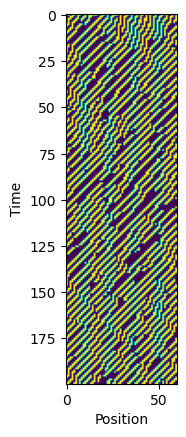

In [448]:

# ruleset = np.array([0, 1, 1, 0, 1, 0, 1, 0]) # Rule 30
# ruleset = np.array([0, 1, 1, 1, 0, 1, 1, 0]) # Rule 110
# ruleset = np.array([0, 0, 0, 1, 1, 1, 0, 1])  # Rule 184
# ruleset = np.array([0, 0, 0, 1, 1, 1, 0, 1])  # Rule 184
# ruleset = np.array([0, 1, 0, 1, 1, 0, 1, 0]) # Rule 90
# ruleset = np.array([0, 1, 1, 0, 1, 0, 0, 1]) # Rule 150
# ruleset = np.array([0, 1, 1, 0, 1, 0, 0, 1]) # Rule 150
# ruleset = np.array([0, 0, 1, 1, 1, 1, 0, 0]) # Rule 60
# ruleset = np.array([0, 1, 1, 0, 1, 1, 0, 0]) # Rule 54
# ruleset = np.array([0, 0, 1, 1, 1, 1, 1, 0]) # Rule 62
# ruleset = np.array([0, 1, 1, 0, 1, 1, 0, 1]) # Rule 182
# ruleset = np.array([0, 1, 1, 1, 1, 0, 0, 1]) # Rule 158
# ruleset = np.array([0, 1, 1, 1, 1, 1, 1, 0]) # Rule 126
# ruleset = np.array([0, 1, 1, 0, 0, 1, 1, 0]) # Rule 102

# ruleset = np.array([0, 1, 0, 0, 1, 1, 0, 0]) # Rule ??

ruleset = np.array([0, 1, 1, 1, 0, 0, 0, 0]) # Rule good

# ruleset = np.array([0, 1, 1, 1, 0, 0, 0, 0])

# ruleset = np.array([0, 1, 1, 1, 0, 1, 1, 0]) # Rule 110
# 000 001 010 011 100 101 110 111
#  0   1   0   1   1   1   0   1

# ruleset = np.array([1,  1,   0,   1,   1,   1,   0,  0]) # Rule ?? Good


all_states = [np.random.choice([0,1], size=60)]

for _ in range(1001):
    prev_state = all_states[-1].copy()
    
    flip_inds = np.random.choice(len(prev_state), 2)
    prev_state[flip_inds] = 1 - prev_state[flip_inds]

    sel_inds = convolve1d(prev_state, 2 ** np.arange(3), mode='wrap').astype(int)


    all_states.append(ruleset[sel_inds])
all_states = np.array(all_states)
plt.imshow(all_states[:200])
plt.xlabel("Position")
plt.ylabel("Time")

# Learning a cellular automaton from data

+ We saw below how to generate XXX. We can see this as a vignette of the problems we've encountered so far in this course: We know the rules that govern a physical system, and we write code that implements those rules, or a close approximation

+ Often, however, we are interested in the inverse problem: We have experimental data, and we want to learn the physical rules that generated it.

+ Suppose that we are purely given a time series of cellular automaton states. Can we learn the rule directly from it? 

+ Our data consists of a time series consisting of $N_\text{data}$ timepoints. Because we want to learn the rules that generated this data, we will split it up into two groups a set of timepoints, and a set of timepoints that immediately follow them in the time series. We refer to these datasets as $X$ and $y$

+ We can think of the learning problem as inferring the unknown function $\mathbf{f}(.)$ such that $\mathbf{y} = \mathbf{f}(\mathbf{x})$



Text(0, 0.5, 'Time')

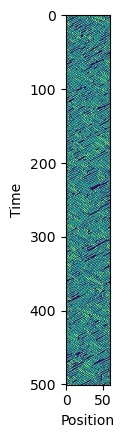

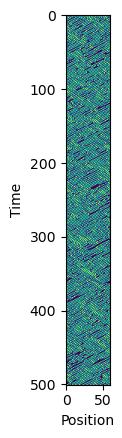

In [449]:
X_all = all_states[::2].copy()
y_all = all_states[1::2].copy()

plt.figure()
plt.imshow(X_all)
plt.xlabel("Position")
plt.ylabel("Time")

plt.figure()
plt.imshow(y_all)
plt.xlabel("Position")
plt.ylabel("Time")

### Training and testing data

+ Rather than fitting our cellular automaton model to all of the data, we will split the data into a training set and a test set. 

+ We will first fit the model to the training set, and then evaluate the trained model on the test set. 

+ This is a common technique in machine learning that is used to avoid overfitting.

In [430]:
# X_all, y_all = list(), list()
# for _ in range(1001):
#     X_all.append(np.random.choice([0,1], size=60))
#     sel_inds = convolve1d(X_all[-1], 2 ** np.arange(3), mode='wrap').astype(int)
#     y_all.append(ruleset[sel_inds])
# X_all, y_all = np.array(X_all), np.array(y_all)

train_test_split = 0.7
n_split = int(train_test_split * X_all.shape[0])
X_train, X_test = X_all[:n_split], X_all[n_split:]
y_train, y_test = y_all[:n_split], y_all[n_split:]


### A note on flattening

+ XXX and $L$ features

+ What if we were learning a 2D cellular automaton? In this case, each snapshot of the system would be an $L x L$ matrix, and we might have $N_\text{data}$ snapshots.

+ Flatten

# Fitting a linear model with least squares

+ What is the simplest function we can think of that maps a vector $\mathbf{y}_{i} \in \mathbb{R}^{L}$ to another vector $\mathbf{y}_{i+1} \in \mathbb{R}^{L}$? Recall that the linear model is defined as

$$
  \mathbf{y}_{i + 1} = A \mathbf{y}_{i}
$$
where $A \in \mathbb{R}^{L \times L}$. 

+ In our case, the features are the state matrices $\mathbf{s}_{(i)}$, and the predictions are the energies $E^{(i)}$. We can directly solve for the matrix $A$ using the ordinary least squares method:

$$
  A = \left( \mathbf{X}^T \mathbf{X} \right)^{-1} \mathbf{X}^T \mathbf{y}
$$

  Recall that we need to use the Moore-Penrose pseudoinverse because the matrix $\mathbf{X}^T \mathbf{X}$ is not square, and the pseudoinverse is the closest thing to an inverse that we can get.

### Python syntax: the `scikit-learn` library

+ Rather than using `numpy`, we will use the Python machine learning library `scikit-learn` to perform the linear regression. 

+ `scikit-learn` uses a consistent API for both simple models, like linear regression, and more complex models, like neural networks.



0.07655203489467569
0.09417028373913075


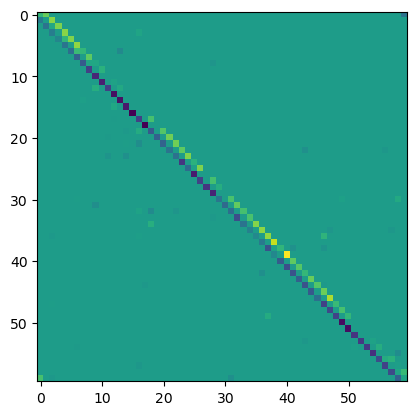

In [450]:
from sklearn.linear_model import LinearRegression, RidgeCV, Lasso

# model = RidgeCV()
model = Lasso(alpha=6e-2)
# model = LinearRegression()

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)

print(np.mean((y_pred_train - y_train)**2))

y_pred_test = model.predict(X_test)

print(np.mean((y_pred_test - y_test)**2))

plt.imshow(model.coef_)

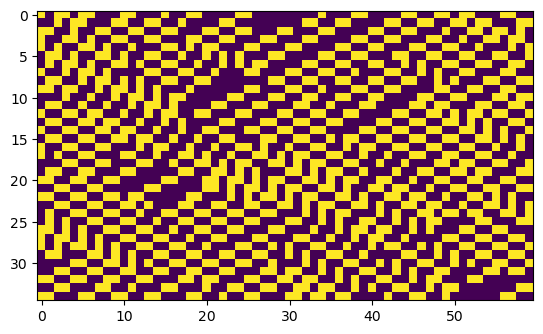

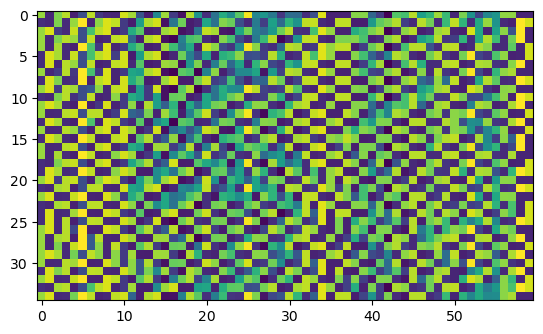

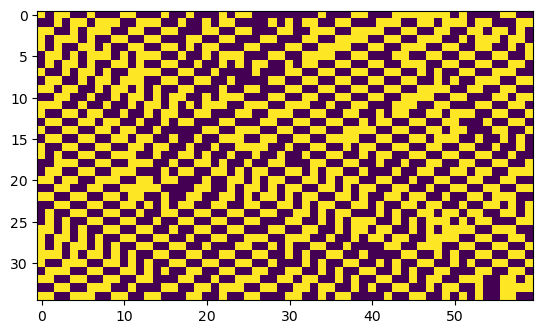

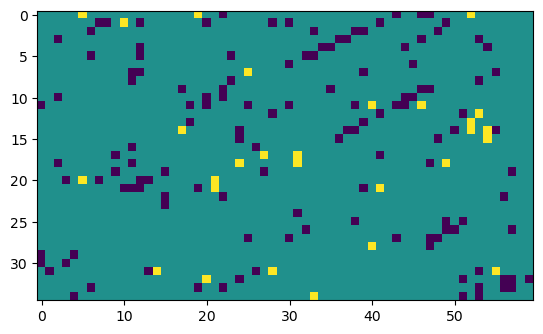

In [434]:
plt.figure()
plt.imshow(y_train[:100])

plt.figure()
plt.imshow(y_pred_train[:100])

plt.figure()
plt.imshow(np.round(y_pred_train[:100]))

plt.figure()
plt.imshow(y_train[-60:] - np.round(y_pred_train[-60:]))

#### What about experiments that the model hasn't seen before?

### Scoring a trained regression model

We can summarize the performance of a regression model by computing the coefficient of determination, $R^2$. This is a measure of how much of the variance in the data is explained by the model. It is defined as
$$
R^2 = 1 - \frac{\sum_i (y_i - \hat{y}_i)^2}{\sum_i (y_i - \langle y \rangle)^2}
$$
where $y_i$ is the true value of the $i^{th}$ sample, $\hat{y}_i$ is the predicted value of the $i^{th}$ sample, and $\langle y \rangle$ is the mean of the true values. An $R^2$ of 1 indicates that the model perfectly predicts the data, while an $R^2$ of 0 indicates that the model is no better than predicting the mean of the data.

### Overfitting
+ High train accuracy just tells us that our model class is capable of expressing patterns found the training data

+ For all datasets, there exists a way to get 100% train accuracy as long as I have access to memory equal to the size of the training dataset (1-nearest-neighbor lookup table)

+ We therefore need to either regularize (training data can't be perfectly fit) or use a test dataset to see how good our model actually is

+ A reasonable heuristic when choosing model complexity is to find one that can just barely overfit train (suggests sufficient power)

## But raw score doesn't tell the whole story

+ We can get a great fit, but our model might have a lot of free parameters
+ There might be multiple valid coupling matrices $J$ that explain the observed data
+ Our model might be predictive but not interpretable, or physical
+ We either need more data, better data (sample rarer states), or a better model


## Let's look at the learned coupling matrix

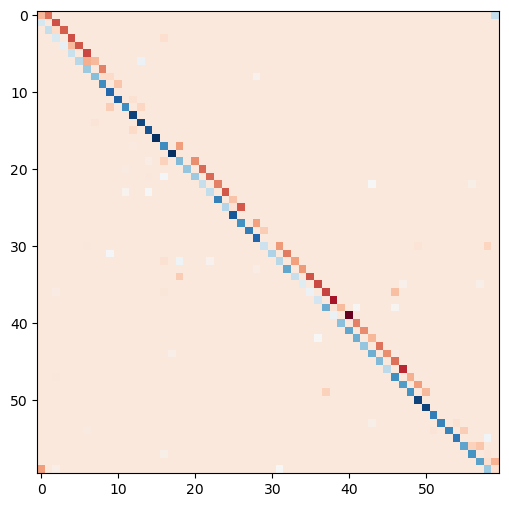

In [451]:
## Because we flattened the data, we need to reshape the coefficients to get the couplings
L = X_train.shape[1]
rules_estimated = np.array(model.coef_)

plt.figure(figsize=(6, 6))
plt.imshow(rules_estimated, cmap='RdBu_r')

#### Let's try repeating the model fitting several times on different subsets of our experimental data

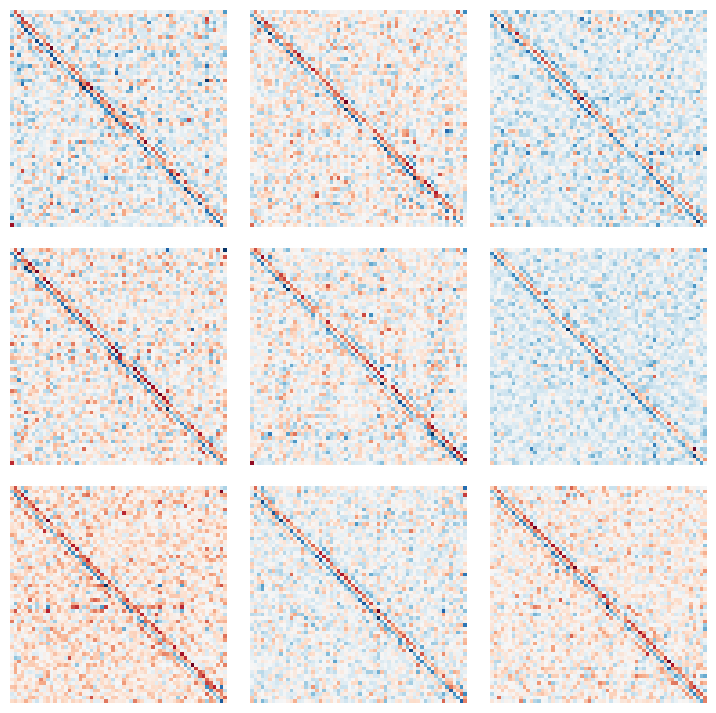

In [452]:
plt.figure(figsize=(9, 9))
## Plot 3 x 3 subplots

n_samples = 20
for i in range(9):

    ## Pick random training data set
    selection_inds = np.random.choice(range(X_all.shape[0]), size=n_samples, replace=False)
    X_train, y_train = X_all[selection_inds], y_all[selection_inds]
    model = LinearRegression()
    model.fit(X_all[selection_inds], y_all[selection_inds])
    rules_estimated = np.array(model.coef_)
    
    ## Plot learned coupling matrix
    plt.subplot(3, 3, i + 1)
    plt.imshow(rules_estimated, cmap='RdBu_r')
    plt.axis('off')

# spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.1)


# Narrowing the model class with regularization

+ We constrain the model's allowed space of valid representations in order to select for more parsimonious models

+ Operationally, regularizers/constraints reduce the "effective" number of parameters, and thus complexity, of our model

+ Imposing preferred basis functions or symmetries can be forms of regularization


### Ridge regression and Lasso:

+ We can think of our least-squares problem as choosing the optimal $J$ that minimizes the following objective function, the mean squared error between the model energies and true energies
$$
\mathcal{L} = \sum_{i=1}^{N_{data}} (\mathbf{X}^{(i)} \cdot \mathbf{J}- E^{(i)})^2
$$ 
+ where $i$ indicates different training examples, which have predicted energies given by $\mathbf{X}^i \cdot \mathbf{J}$ and observed energies of $H^i$

+ Common regularizers associated loss with the trainable parameters of the model. 

+ **Ridge regression** is also known as $L2$ regularization, and it discourages any particular weight in the coefficient matrix from becoming too large. Ridge imposes a degree of smoothness or regularity across how a model treats its various inputs. Models that take continuous data as inputs (such as time series, or images), may benefit from the ridge term.

+ + If $\mathbf{J}$ is our trainable linear regression weight matrix (and, in this context, our best estimate for the spin-spin interaction matrix), then we can modify the the losses as follows:
$$
\mathcal{L}_{Lasso} = \sum_{i=1}^{N_{data}} (\mathbf{X}^{(i)} \cdot \mathbf{J}- E^{(i)})^2 + \lambda \sum_{jk} | J_{jk} |
$$



+ **Lasso** is also known as $L1$ regularization, and it encourages *sparsity* in weight space: it incentivizes models were most coefficients go to zero, thereby reducing the models dependencies on features. Lasso is often used in feature selection, where we want to identify the most important features in a dataset.

$$
\mathcal{L}_{Ridge} = \sum_{i=1}^{N_{data}} (\mathbf{X}^{(i)} \cdot \mathbf{J}- E^{(i)})^2 + \lambda \sum_{jk} J_{jk}^2
$$
where the hyperparameter $\lambda$ determines the "strength" of the penalty terms.



Let's try re-fitting the model with these different regularizers. We will vary $\lambda$, the strength of the regularization, and see how the learned coupling matrix changes.

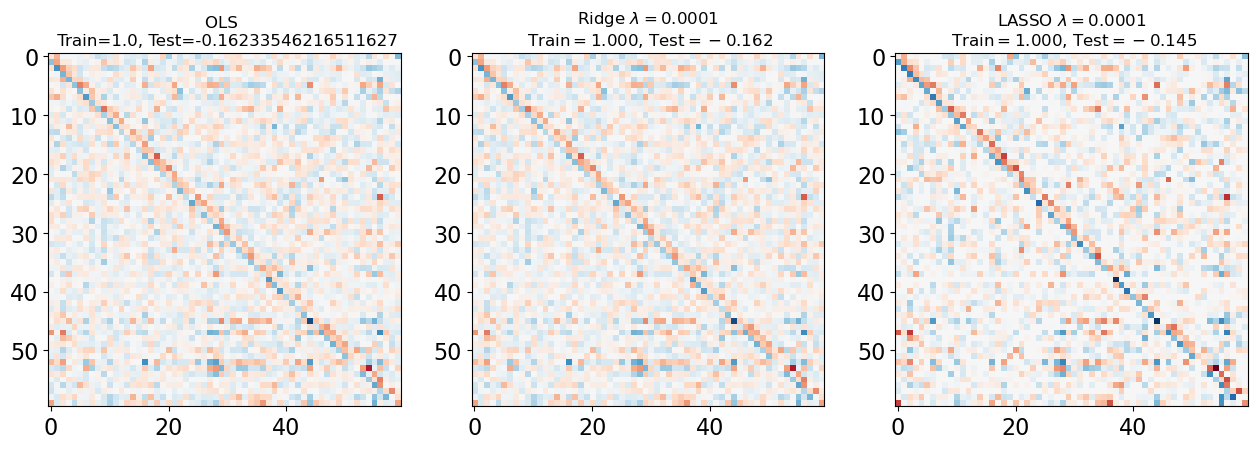

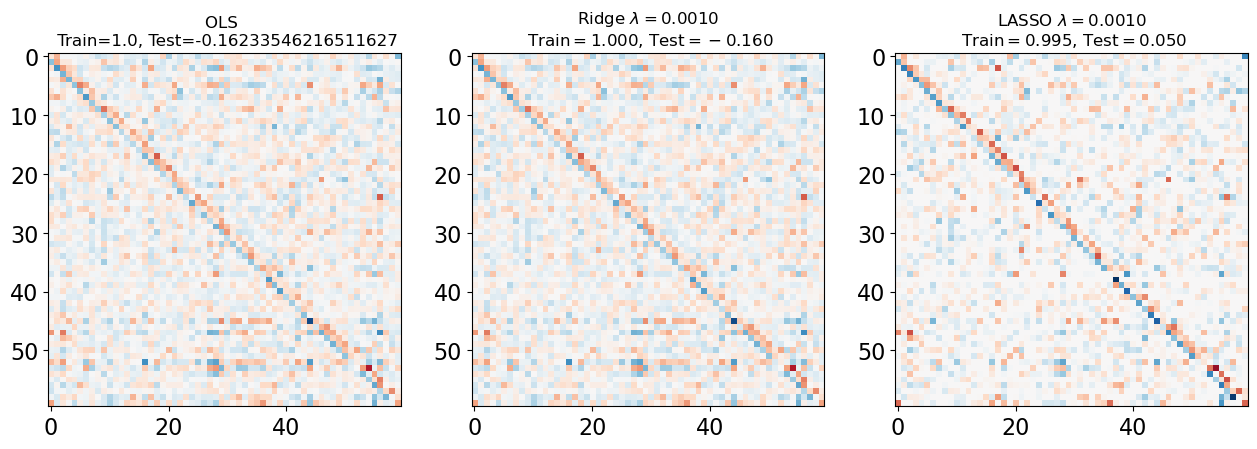

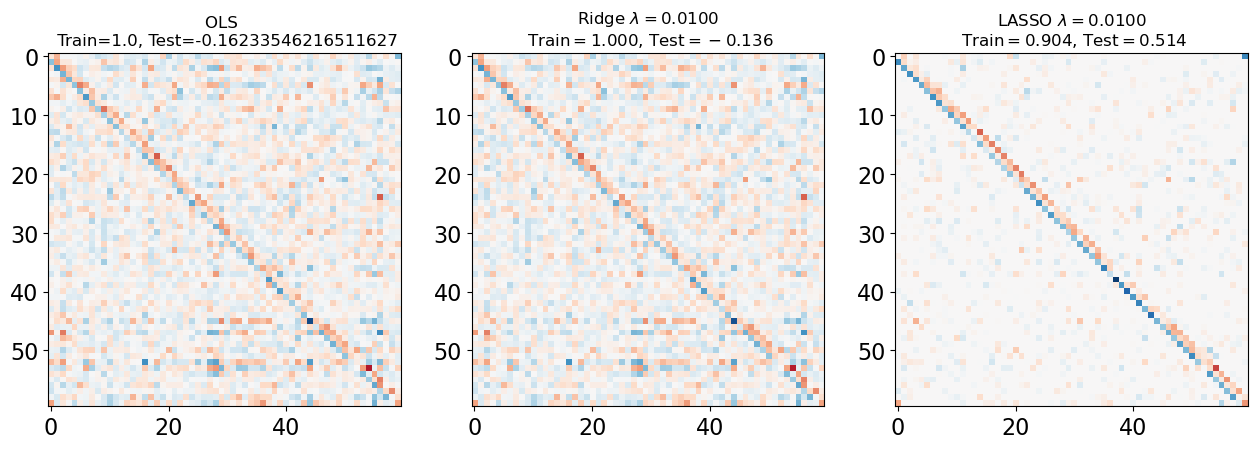

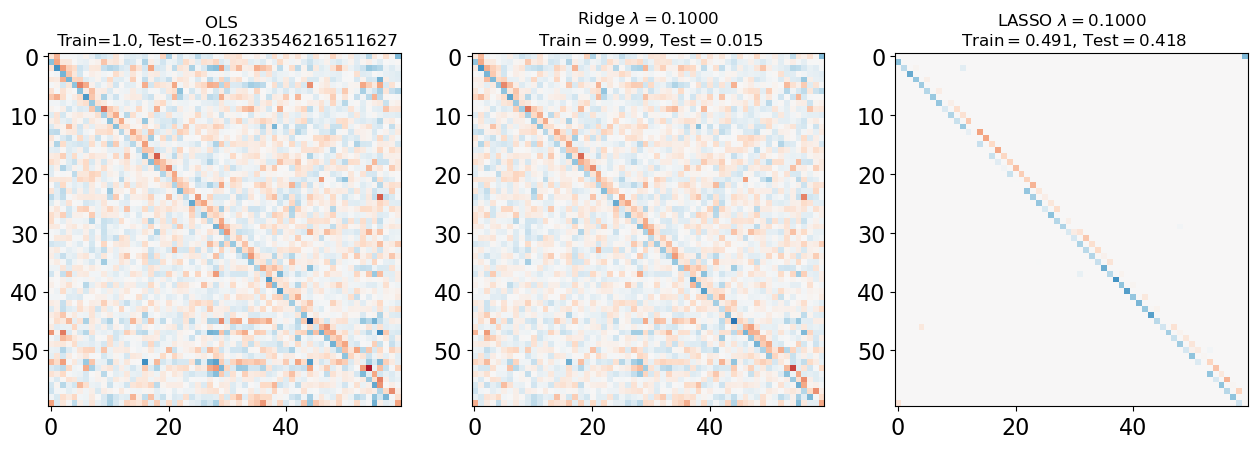

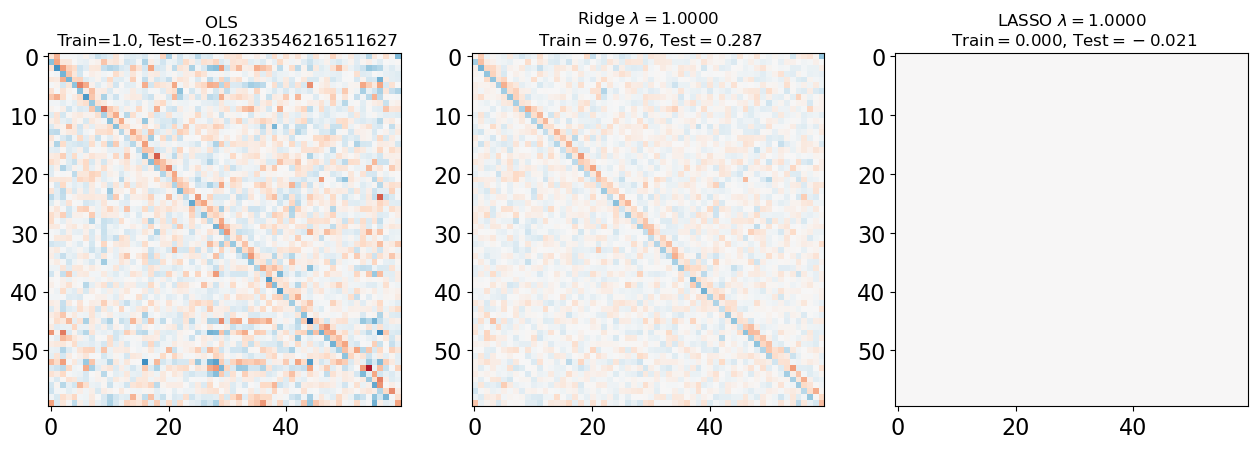

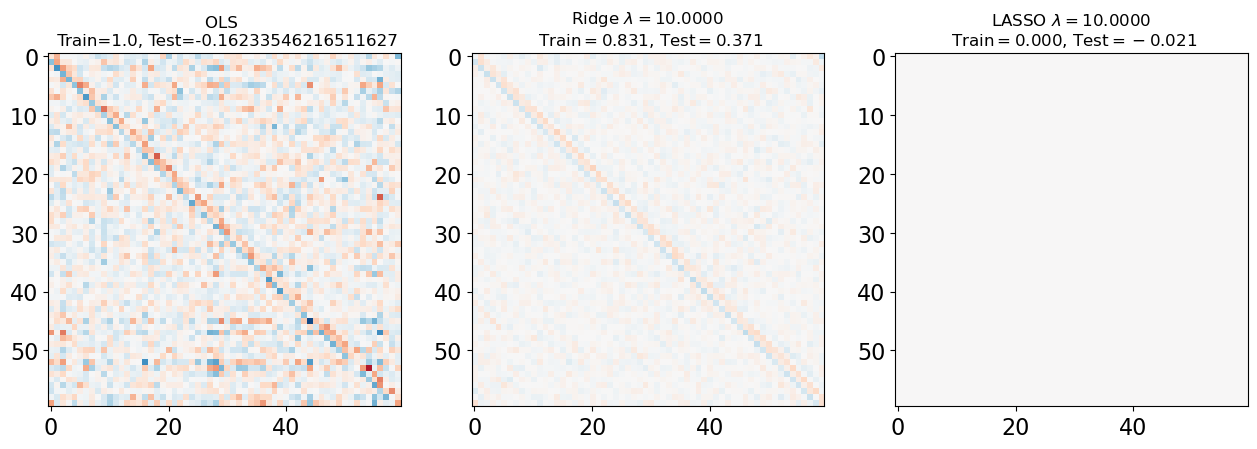

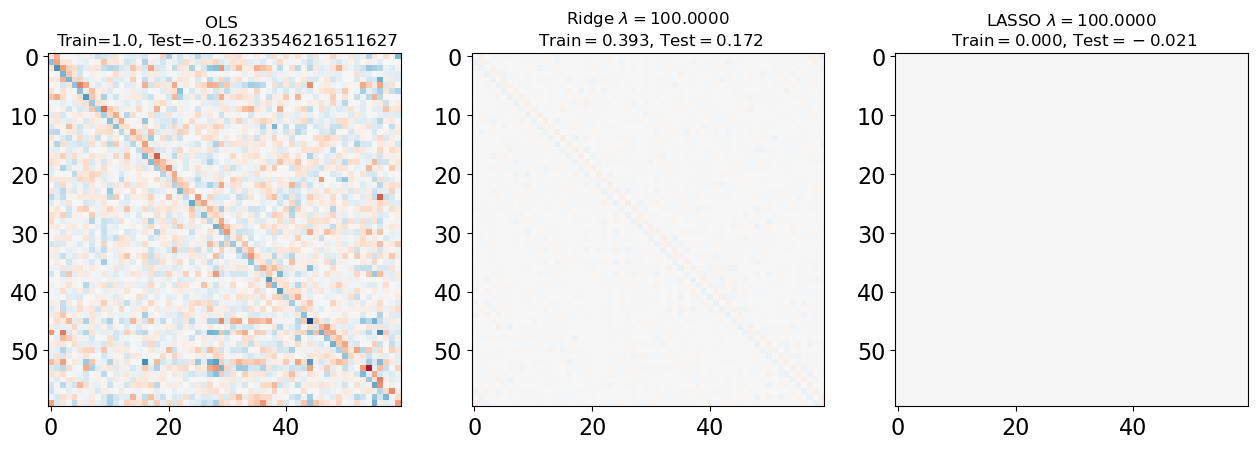

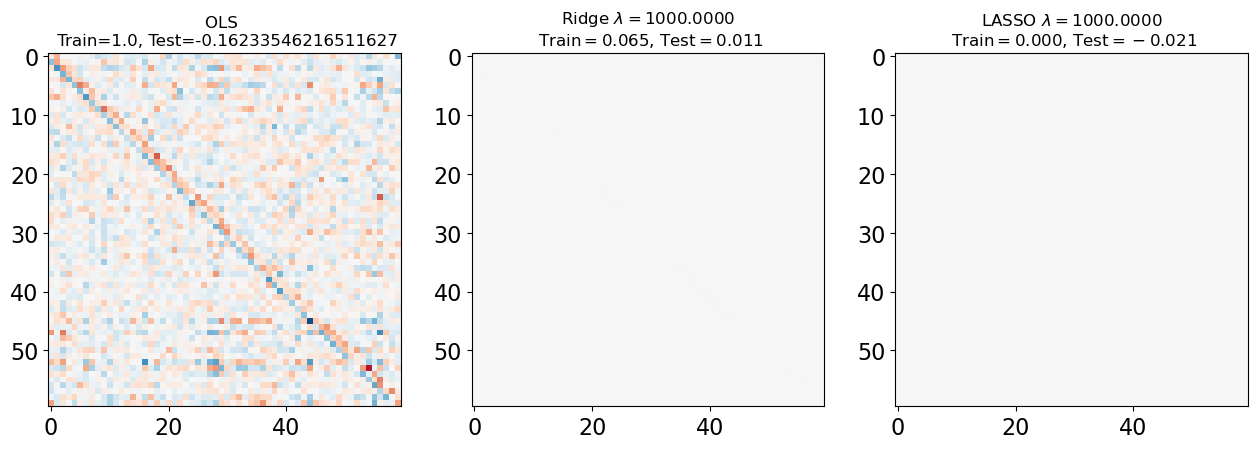

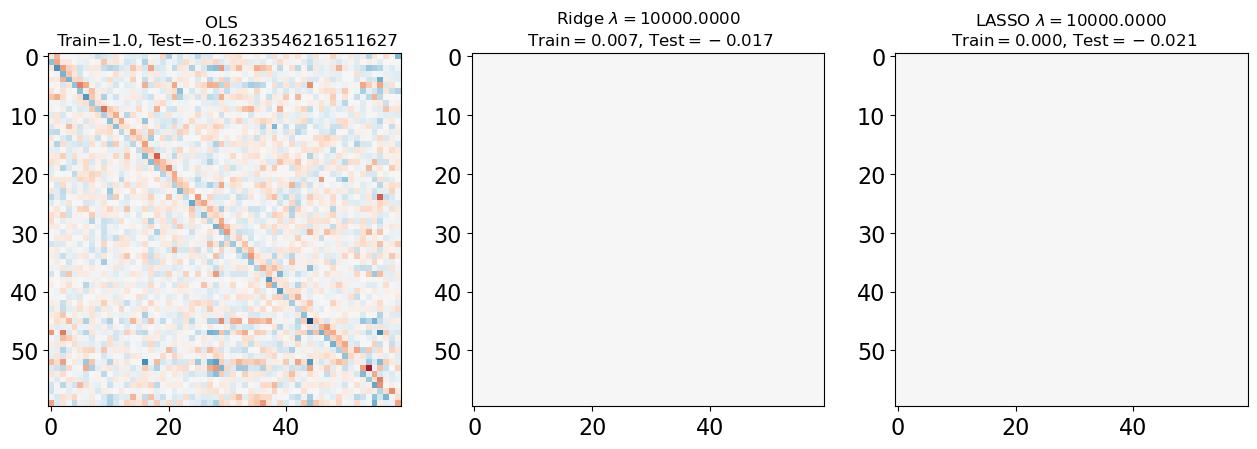

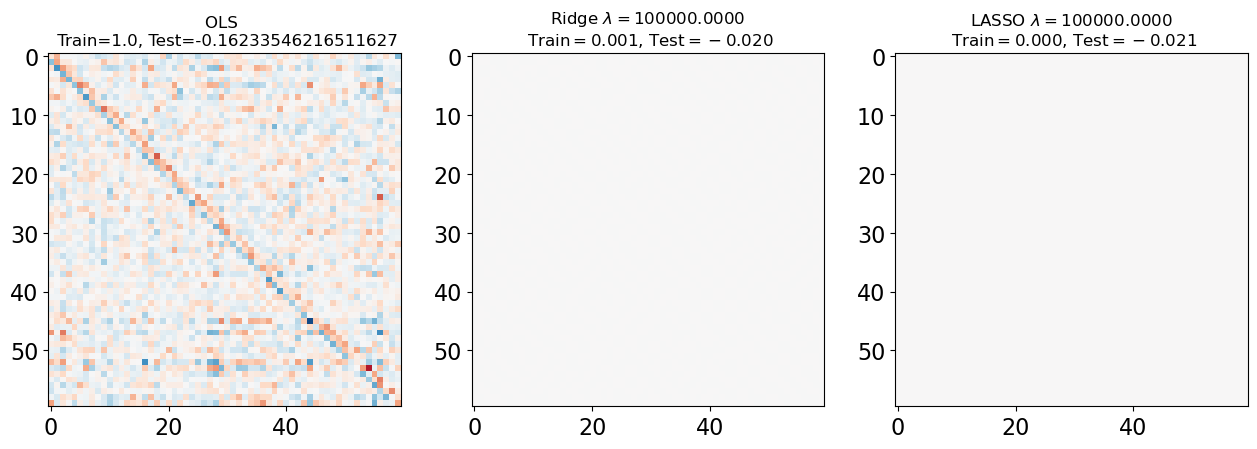

In [453]:


# Instantiate models
from sklearn import linear_model
model_ols = linear_model.LinearRegression()
model_l2 = linear_model.Ridge()
model_l1= linear_model.Lasso()

# Set regularization range
lambdas = np.logspace(-4, 5, 10)

# Load data
# define subset of samples
n_samples = 40
X_train, X_test = X_all[:n_samples], X_all[n_samples : 3 * n_samples // 2]
y_train, y_test = y_all[:n_samples], y_all[n_samples : 3 * n_samples // 2]

# define error lists
train_error_ols, test_error_ols = list(), list()
train_error_l2, test_error_l2 = list(), list()
train_error_l1, test_error_l1 = list(), list()

#Initialize coefficients for ridge regression and Lasso
coeffs_ols, coeffs_ridge, coeffs_lasso = list(), list(), list()

for lam in lambdas:
    ### ordinary least squares
    model_ols.fit(X_train, y_train) # fit model 
    coeffs_ols.append(model_ols.coef_) # store weights
    # use the coefficient of determination R^2 as the performance of prediction.
    train_error_ols.append(model_ols.score(X_train, y_train))
    test_error_ols.append(model_ols.score(X_test, y_test))

    ### ridge regression
    model_l2.set_params(alpha=lam) # set regularisation strength
    model_l2.fit(X_train, y_train) # fit model
    coeffs_ridge.append(model_l2.coef_) # store weights
    train_error_l2.append(model_l2.score(X_train, y_train))
    test_error_l2.append(model_l2.score(X_test, y_test))

    ### lasso
    model_l1.set_params(alpha=lam) # set regularisation strength
    model_l1.fit(X_train, y_train) # fit model
    coeffs_lasso.append(model_l1.coef_) # store weights
    train_error_l1.append(model_l1.score(X_train, y_train))
    test_error_l1.append(model_l1.score(X_test, y_test))




    ### plot Ising interaction J
    J_leastsq = np.array(model_ols.coef_).reshape((L, L))
    J_ridge = np.array(model_l2.coef_).reshape((L, L))
    J_lasso = np.array(model_l1.coef_).reshape((L, L))


    fig, axarr = plt.subplots(nrows=1, ncols=3)
    
    axarr[0].imshow(J_leastsq,  cmap="RdBu_r", vmin=-1, vmax=1)
    axarr[0].set_title(f"OLS \n Train={train_error_ols[-1]}, Test={test_error_ols[-1]}")
    ## 3 sig figs
    # axarr[0].set_title('OLS \n Train$=%.3f$, Test$=%.3f$' %(train_error_ols[-1],test_error_ols[-1]))
    axarr[1].set_title('OLS $\lambda=%.4f$\n Train$=%.3f$, Test$=%.3f$' %(lam, train_error_ols[-1],test_error_ols[-1]))
    axarr[0].tick_params(labelsize=16)
    
    axarr[1].imshow(J_ridge,  cmap="RdBu_r", vmin=-1, vmax=1)
    axarr[1].set_title('Ridge $\lambda=%.4f$\n Train$=%.3f$, Test$=%.3f$' %(lam, train_error_l2[-1],test_error_l2[-1]))
    axarr[1].tick_params(labelsize=16)
    
    im=axarr[2].imshow(J_lasso, cmap="RdBu_r", vmin=-1, vmax=1)
    axarr[2].set_title('LASSO $\lambda=%.4f$\n Train$=%.3f$, Test$=%.3f$' %(lam, train_error_l1[-1],test_error_l1[-1]))
    axarr[2].tick_params(labelsize=16)
    
    # divider = make_axes_locatable(axarr[2])
    # cax = divider.append_axes("right", size="5%", pad=0.05, add_to_figure=True)
    # cbar=fig.colorbar(im, cax=cax)
    
    # cbar.ax.set_yticklabels(np.arange(-1.0, 1.0+0.25, 0.25),fontsize=14)
    # cbar.set_label('$J_{i,j}$',labelpad=15, y=0.5,fontsize=20,rotation=0)
    
    fig.subplots_adjust(right=2.0)
    
    plt.show()

Text(0, 0.5, 'Performance $R^2$')

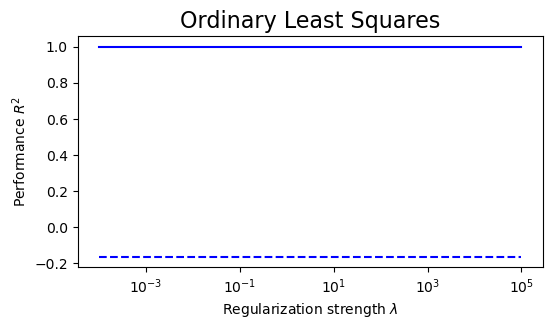

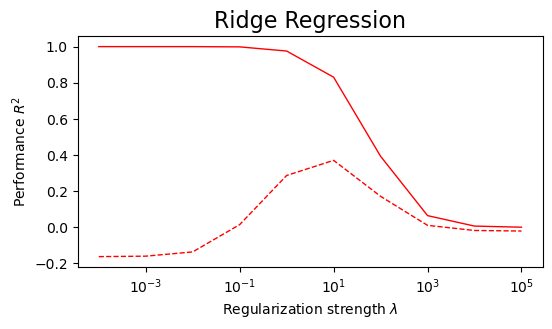

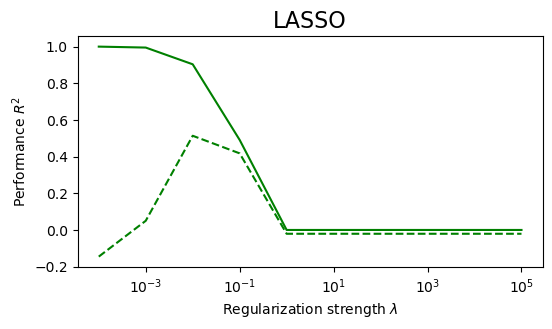

In [454]:
# Plot our performance on both the training and test data
plt.figure(figsize=(6, 3))
plt.semilogx(lambdas, train_error_ols, "b", label="Train (OLS)")
plt.semilogx(lambdas, test_error_ols, "--b", label="Test (OLS)")
plt.title("Ordinary Least Squares", fontsize=16)
plt.xlabel("Regularization strength $\lambda$")
plt.ylabel("Performance $R^2$")


plt.figure(figsize=(6, 3))
plt.semilogx(lambdas, train_error_l2, "r", label="Train (Ridge)", linewidth=1)
plt.semilogx(lambdas, test_error_l2, "--r", label="Test (Ridge)", linewidth=1)
plt.title("Ridge Regression", fontsize=16)
plt.xlabel("Regularization strength $\lambda$")
plt.ylabel("Performance $R^2$")

plt.figure(figsize=(6, 3))
plt.semilogx(lambdas, train_error_l1, "g", label="Train (LASSO)")
plt.semilogx(lambdas, test_error_l1, "--g", label="Test (LASSO)")
plt.title("LASSO", fontsize=16)
plt.xlabel("Regularization strength $\lambda$")
plt.ylabel("Performance $R^2$")


array([4, 1, 3, 0, 1])

## Spin glasses

+ A spin glass has a Hamiltonian of the form

  $$
  H(\mathbf{s}^{(i)}) = - \sum_{jk} J_{jk} s_{j}^{(i)} \, s_{k}^{(i)}.
  $$
  where $s_{j}^{(i)} \in \{-1, 1\}$ is the spin of the $j^{th}$ spin in the $i^{th}$ experimental sample $\mathbf{s}^{(i)}$, and $J_{jk}$ is the interaction strength between the $j^{th}$ and $k^{th}$ spins. We assume that there are $L$ spins, and that the sum is over all $L(L-1)/2$ pairs of spins. 

+ In general, the coupling matrix is not symmetric $J_{jk} \neq J_{kj}$, and the diagonal elements are zero $J_{jj} = 0$ (no self-interactions)

+ Depending on the coupling matrix $J_{j,k}$, the system can be ferromagnetic, anti-ferromagnetic, or a spin glass. In a ferromagnet, all spins prefer to be aligned. In an anti-ferromagnet, all spins prefer to be anti-aligned. In a spin glass, there is no global preference for alignment or anti-alignment. Instead, the system is frustrated, and the spins cannot simultaneously minimize their energy.






### Lod experimental measurements of an unknown spin glass

+ Suppose we have a spin glass with $L$ spins. 

+ Our data consists of $N_\text{data}$ measurements of microstates $\mathbf{s}^{(i)}$, and their respective energies $E^{(i)} = H(\mathbf{s}^{(i)})$.

In [79]:
microstates = np.load('../resources/spin_microstates.npy', allow_pickle=True)
energies = np.load('../resources/spin_energies.npy', allow_pickle=True)

print("Microstates shape: ", microstates.shape)
print("Energies shape: ", energies.shape)

Microstates shape:  (10000, 40)
Energies shape:  (10000,)


Text(0, 0.5, 'Number of microstates')

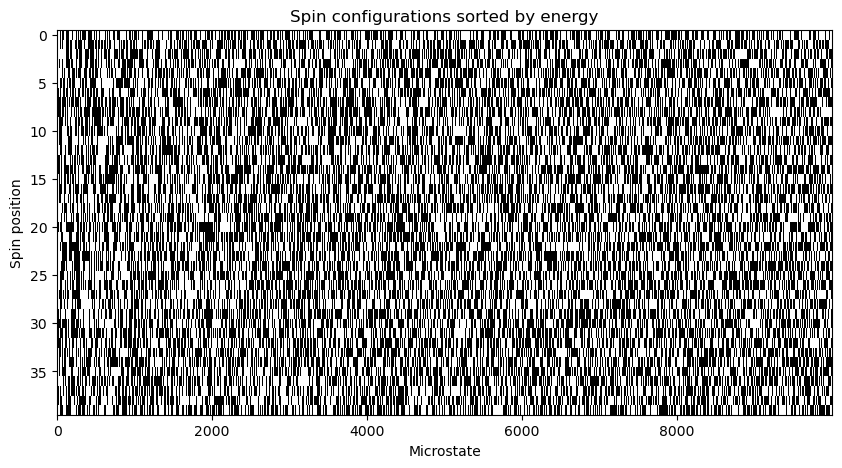

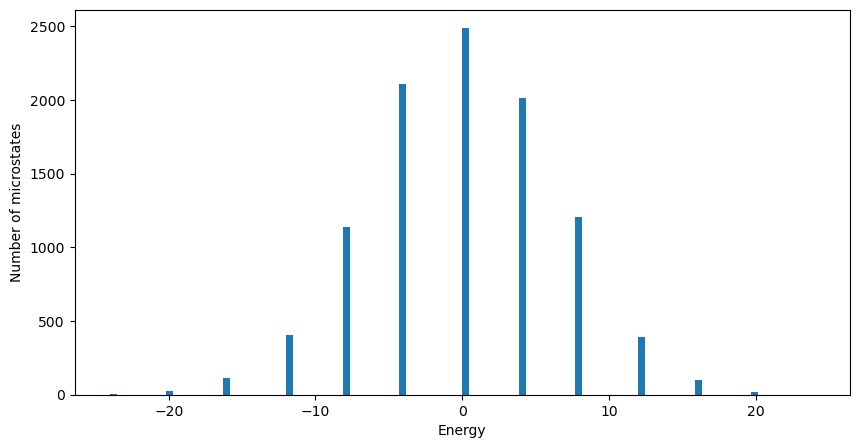

In [80]:


plt.figure(figsize=(10, 5))
plt.imshow(
    microstates[np.argsort(energies)].T, 
    interpolation='nearest', aspect='auto', cmap='binary'
)
plt.ylabel("Spin position")
plt.xlabel("Microstate")
plt.title("Spin configurations sorted by energy")
## aspect ratio
# plt.gca().set_aspect('auto')

plt.figure(figsize=(10, 5))
plt.hist(energies, bins=100)
plt.xlabel("Energy")
plt.ylabel("Number of microstates")


## Can we infer the unknown $J_{jk}$, given only the samples and their energies?


Our model class is defined as our known energy function for each sample,

$$
H(\mathbf{s}^{(i)}) = - \sum_{jk} J_{jk} s_{j}^{(i)} \, s_{k}^{(i)}.
$$

We can define the vector $\mathbf{X}^i$ with components

$$
\mathbf{X}^{(i)}_{jk} = s_j^{(i)} s_k^{(i)}.
$$

or, in vector notation,

$$
\mathbf{X}^{(i)} = \mathbf{s}^{(i)} \otimes \mathbf{s}^{(i)}.
$$

Then the energy of each sample is

$$
E^{(i)} = - \sum_{jk} J_{jk} \mathbf{X}^{(i)}_{jk}.
$$

Notice that we've exploited our prior knowledge of the physics of this problem in order to put the problem into a linear form. This represents a sort of *feature engineering* where we've used an *inductive bias* to make the problem easier to solve.


### A note on flattening

Notice that our Hamiltonian contains a double sum, which indexes into two matrices. Rather than keeping track of two indices, we can flatten the matrices into vectors, and use a single index. 

Flattening over features space is a common technique in machine learning, which we previously used in order to apply PCA to image data.


In [81]:
X_all = microstates[:, :, None] * microstates[:, None, :] # outer product creates neighbor matrix
print("X_all shape: ", X_all.shape)

# Data matrix / design matrix always has shape (n_samples, n_features)
X_all = np.reshape(X_all, (X_all.shape[0], -1)) 
print("X_all shape after flattening into data matrix: ", X_all.shape)

# Match our label shape
y_all = energies
print("y_all shape: ", y_all.shape)

X_all shape:  (10000, 40, 40)
X_all shape after flattening into data matrix:  (10000, 1600)
y_all shape:  (10000,)


### Training and testing data

+ Rather than fitting our Hamiltonian model to all of the data, we will split the data into a training set and a test set. 

+ We will fit the model to the training set, and then evaluate the trained model on the test set. 

+ This is a common technique in machine learning, and is used to avoid overfitting.

In [82]:

# define subset of samples
n_samples = 400

# define train and test data sets
X_train, X_test = X_all[:n_samples], X_all[n_samples : 3 * n_samples // 2]
y_train, y_test = y_all[:n_samples], y_all[n_samples : 3 * n_samples // 2]

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape, "\n")

print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (400, 1600)
y_train shape:  (400,) 

X_test shape:  (200, 1600)
y_test shape:  (200,)


# Fitting a linear model with least squares

+ Because our Hamiltonian is linear with respect to the *outer product* state matrices, we expect that linear regression is a good way to infer the coupling matrix $J_{jk}$.

+ Recall that the linear model is defined as

  $$
  \hat{y} = A \cdot \mathbf{x}
  $$
  where $A$ is a matrix, then $\mathbf{x}$ is a vector of features, and $\hat{y}$ is a vector of predictions.

+ In our case, the features are the outer product state matrices $\mathbf{X}^{(i)}$, and the predictions are the energies $E^{(i)}$. We can directly solve for the matrix $A$ using the least squares method:
  $$
  A = \left( \mathbf{X}^T \mathbf{X} \right)^{-1} \mathbf{X}^T \mathbf{y}
  $$

  Recall that we need to use the Moore-Penrose pseudoinverse because the matrix $\mathbf{X}^T \mathbf{X}$ is not square, and the pseudoinverse is the closest thing to an inverse that we can get.

### `scikit-learn` 

+ Rather than using numpy, we will use the Python machine learning library `scikit-learn` to perform the linear regression. 

+ `scikit-learn` uses a consistent API for both simple models, like linear regression, and more complex models, like neural networks.



In [83]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)

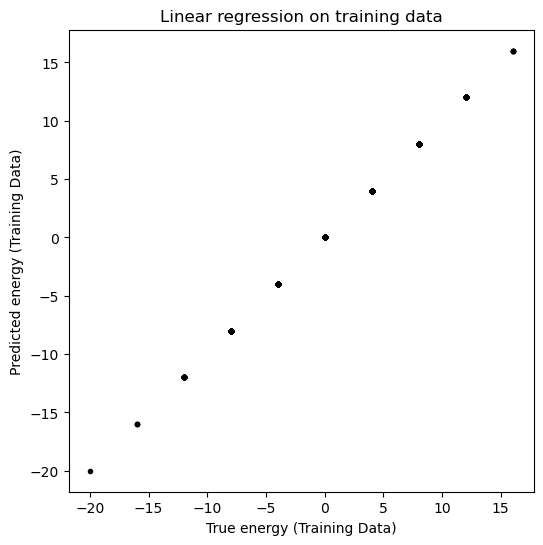

In [84]:
plt.figure(figsize=(6, 6))
plt.plot(y_train, y_pred_train, ".k")
plt.xlabel("True energy (Training Data)")
plt.ylabel("Predicted energy (Training Data)")
plt.title("Linear regression on training data")
plt.gca().set_aspect('auto')



What about experiments that the model hasn't seen before?

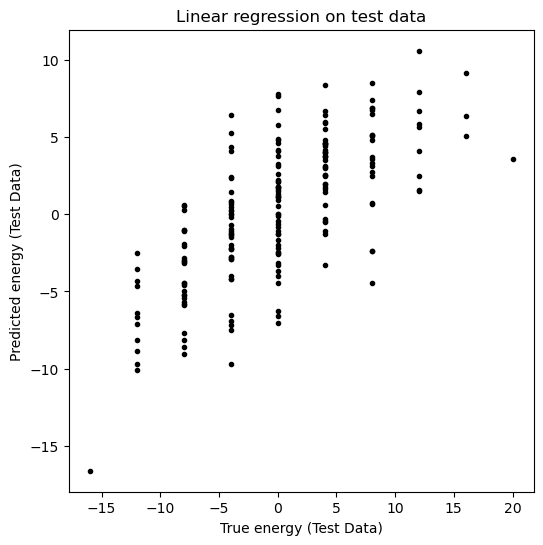

In [85]:
y_pred_test = model.predict(X_test)
# y_pred_test = model.predict(X_test)
plt.figure(figsize=(6, 6))
plt.plot(y_test, y_pred_test, ".k")
plt.xlabel("True energy (Test Data)")
plt.ylabel("Predicted energy (Test Data)")
plt.title("Linear regression on test data")
plt.gca().set_aspect('auto')

### Overfitting
+ High train accuracy just tells us that our model class is capable of expressing patterns found the training data

+ For all datasets, there exists a way to get 100% train accuracy as long as I have access to memory equal to the size of the training dataset (1-nearest-neighbor lookup table)

+ We therefore need to either regularize (training data can't be perfectly fit) or use a test dataset to see how good our model actually is

+ A reasonable heuristic when choosing model complexity is to find one that can just barely overfit train (suggests sufficient power)

### Scoring a trained regression model

We can summarize the performance of a regression model by computing the coefficient of determination, $R^2$. This is a measure of how much of the variance in the data is explained by the model. It is defined as
$$
R^2 = 1 - \frac{\sum_i (y_i - \hat{y}_i)^2}{\sum_i (y_i - \langle y \rangle)^2}
$$
where $y_i$ is the true value of the $i^{th}$ sample, $\hat{y}_i$ is the predicted value of the $i^{th}$ sample, and $\langle y \rangle$ is the mean of the true values. An $R^2$ of 1 indicates that the model perfectly predicts the data, while an $R^2$ of 0 indicates that the model is no better than predicting the mean of the data.

In [86]:
print("Train error was:", model.score(X_train, y_train))
print("Test error was:", model.score(X_test, y_test))

Train error was: 1.0
Test error was: 0.4943462162181823


## But raw score doesn't tell the whole story

+ We can get a great fit, but our model might have a lot of free parameters
+ There might be multiple valid coupling matrices $J$ that explain the observed data
+ Our model might be predictive but not interpretable, or physical
+ We either need more data, better data (sample rarer states), or a better model


## Let's look at the learned coupling matrix

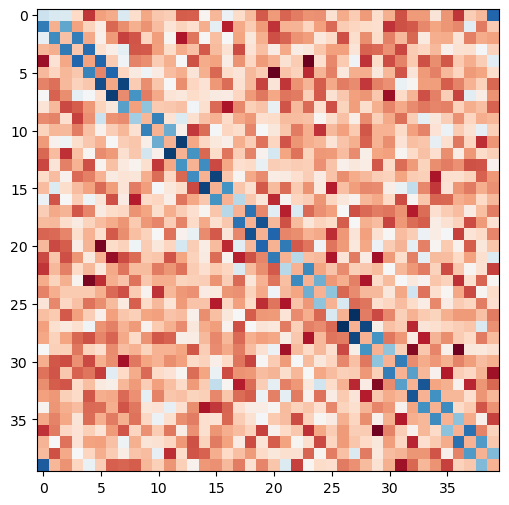

In [87]:
## Because we flattened the data, we need to reshape the coefficients to get the couplings
L = microstates.shape[1]
couplings_estimated = np.array(model.coef_).reshape((L, L))

plt.figure(figsize=(6, 6))
plt.imshow(couplings_estimated, cmap='RdBu_r')

## Let's try repeating the model fitting several times on different subsets of our experimental data

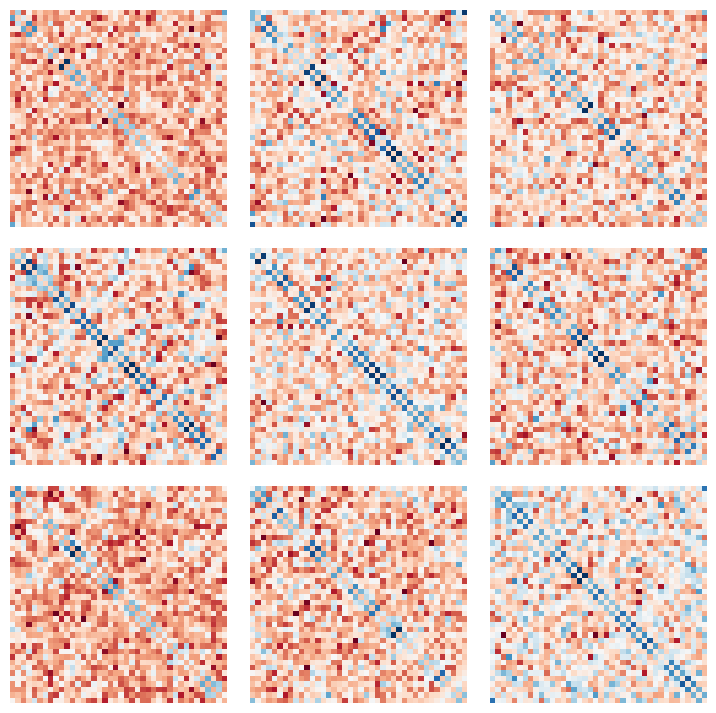

In [90]:


plt.figure(figsize=(9, 9))
## Plot 3 x 3 subplots

n_samples = 200
for i in range(9):

    ## Pick random training data set
    selection_inds = np.random.choice(range(X_all.shape[0]), size=n_samples, replace=False)
    X_train, y_train = X_all[selection_inds], y_all[selection_inds]
    model = LinearRegression()
    model.fit(X_all[selection_inds], y_all[selection_inds])
    couplings_estimated = np.array(model.coef_).reshape((L, L))
    
    ## Plot learned coupling matrix
    plt.subplot(3, 3, i + 1)
    plt.imshow(couplings_estimated, cmap='RdBu_r')
    plt.axis('off')

# spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.1)





    

# Narrowing the model class with regularization

+ We constrain the model's allowed space of valid representations in order to select for more parsimonious models

+ Operationally, regularizers/constraints reduce the "effective" number of parameters, and thus complexity, of our model

+ Imposing preferred basis functions or symmetries can be forms of regularization


### Ridge regression and Lasso:

+ We can think of our least-squares problem as choosing the optimal $J$ that minimizes the following objective function, the mean squared error between the model energies and true energies
$$
\mathcal{L} = \sum_{i=1}^{N_{data}} (\mathbf{X}^{(i)} \cdot \mathbf{J}- E^{(i)})^2
$$ 
+ where $i$ indicates different training examples, which have predicted energies given by $\mathbf{X}^i \cdot \mathbf{J}$ and observed energies of $H^i$

+ Common regularizers associated loss with the trainable parameters of the model. 

+ **Ridge regression** is also known as $L2$ regularization, and it discourages any particular weight in the coefficient matrix from becoming too large. Ridge imposes a degree of smoothness or regularity across how a model treats its various inputs. Models that take continuous data as inputs (such as time series, or images), may benefit from the ridge term.

+ + If $\mathbf{J}$ is our trainable linear regression weight matrix (and, in this context, our best estimate for the spin-spin interaction matrix), then we can modify the the losses as follows:
$$
\mathcal{L}_{Lasso} = \sum_{i=1}^{N_{data}} (\mathbf{X}^{(i)} \cdot \mathbf{J}- E^{(i)})^2 + \lambda \sum_{jk} | J_{jk} |
$$



+ **Lasso** is also known as $L1$ regularization, and it encourages *sparsity* in weight space: it incentivizes models were most coefficients go to zero, thereby reducing the models dependencies on features. Lasso is often used in feature selection, where we want to identify the most important features in a dataset.

$$
\mathcal{L}_{Ridge} = \sum_{i=1}^{N_{data}} (\mathbf{X}^{(i)} \cdot \mathbf{J}- E^{(i)})^2 + \lambda \sum_{jk} J_{jk}^2
$$
where the hyperparameter $\lambda$ determines the "strength" of the penalty terms.



Let's try re-fitting the model with these different regularizers. We will vary $\lambda$, the strength of the regularization, and see how the learned coupling matrix changes.

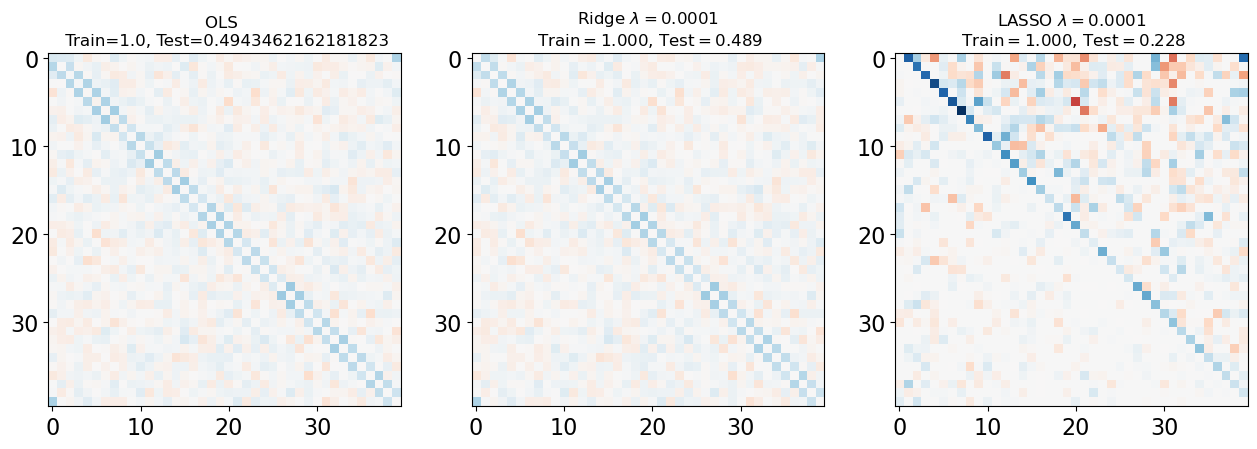

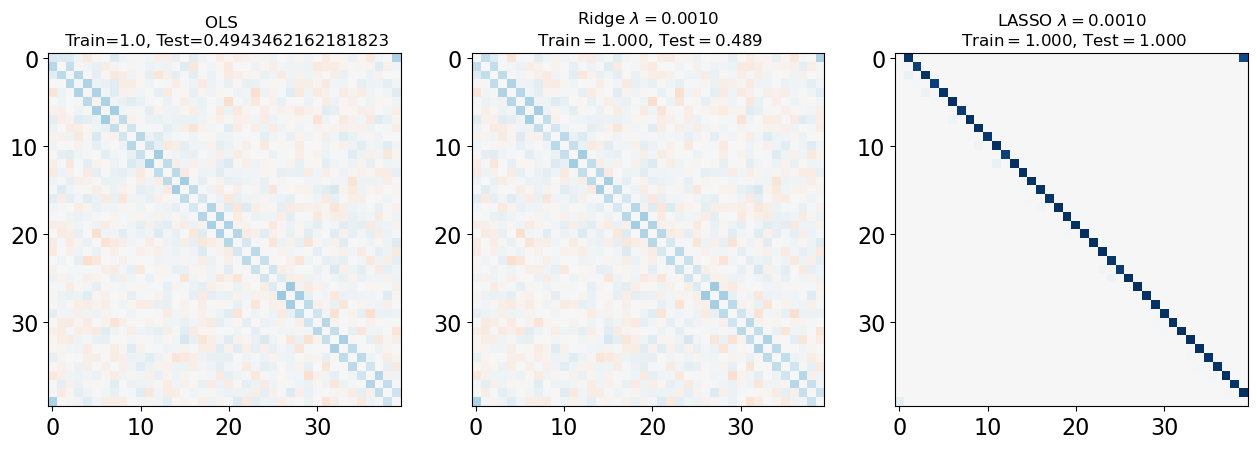

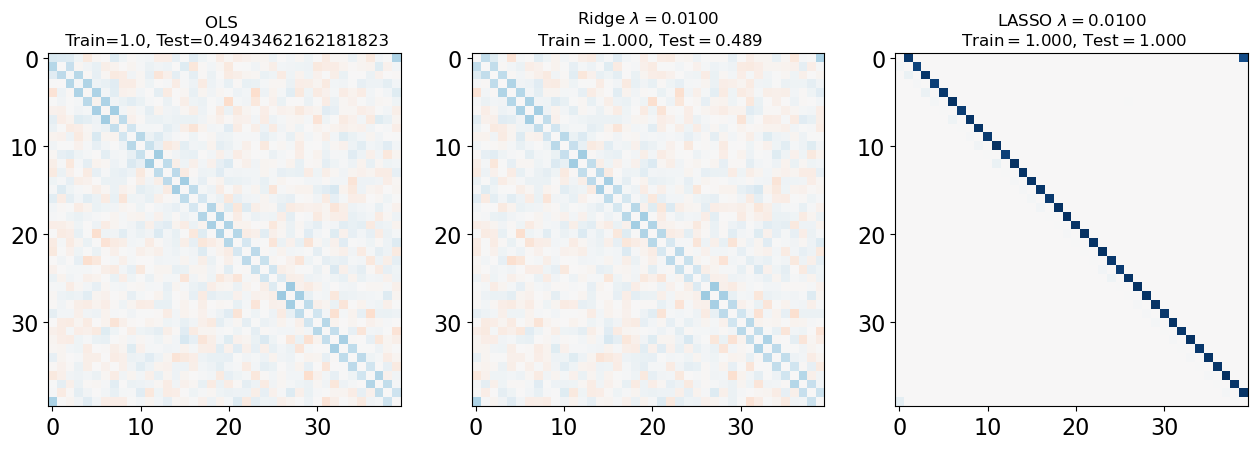

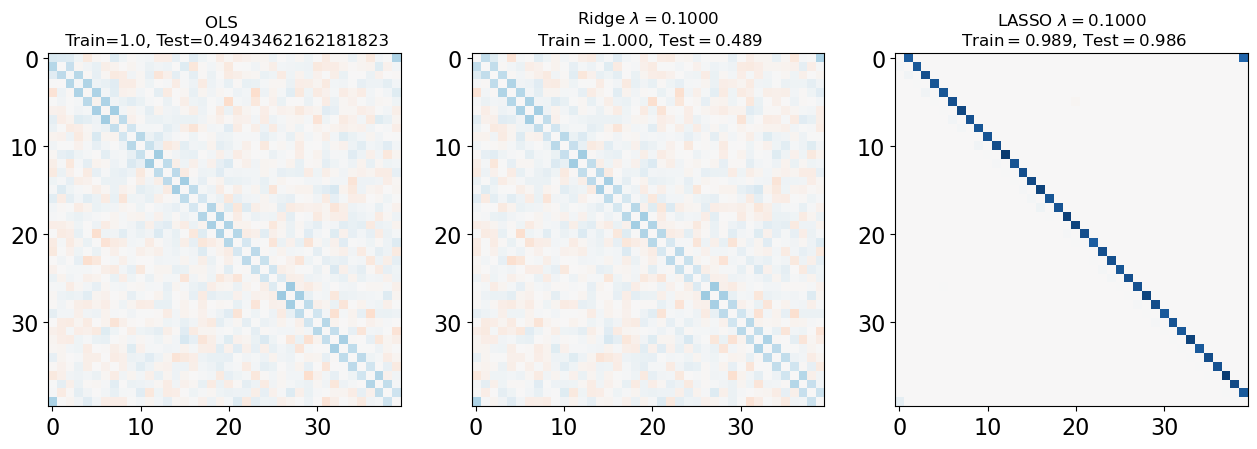

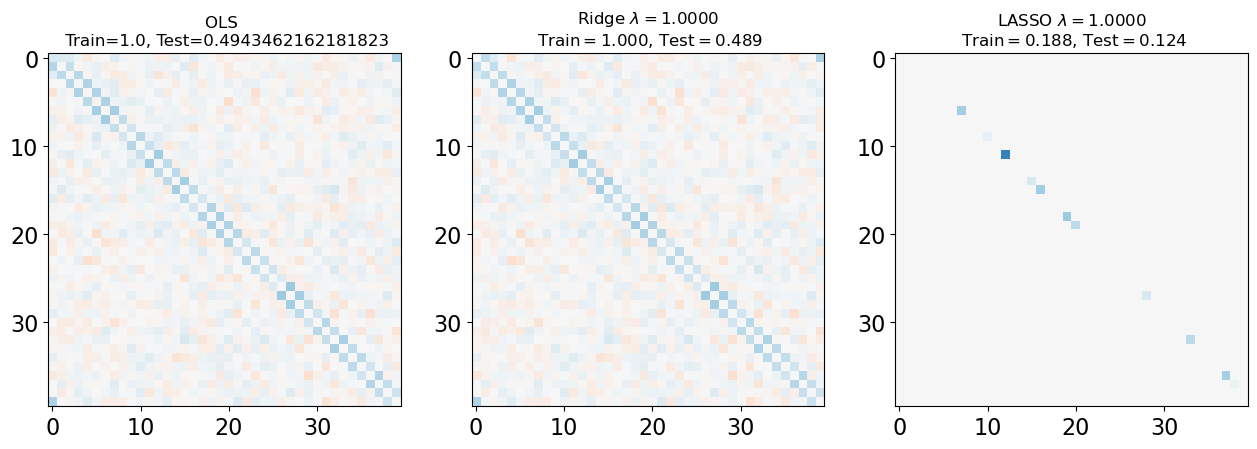

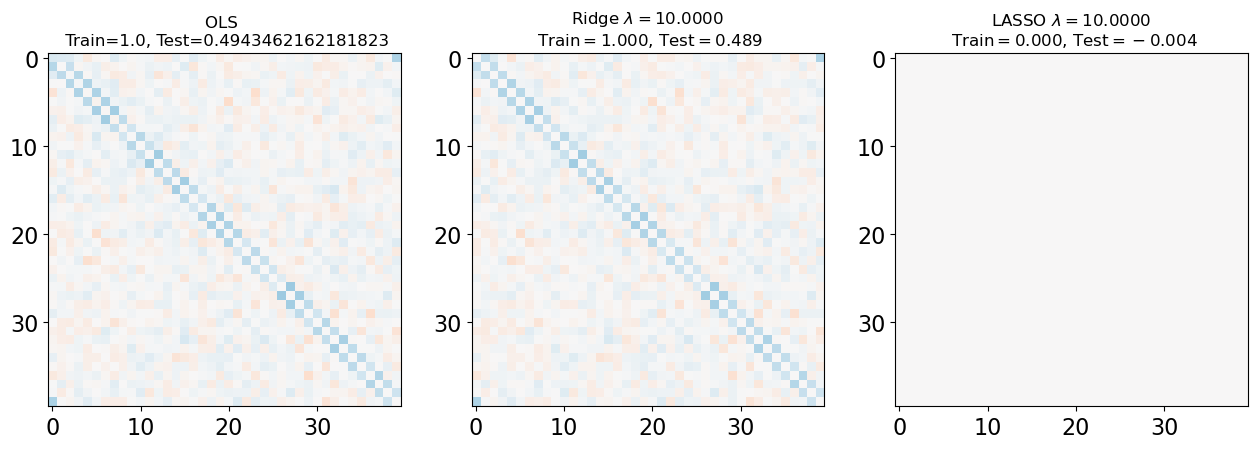

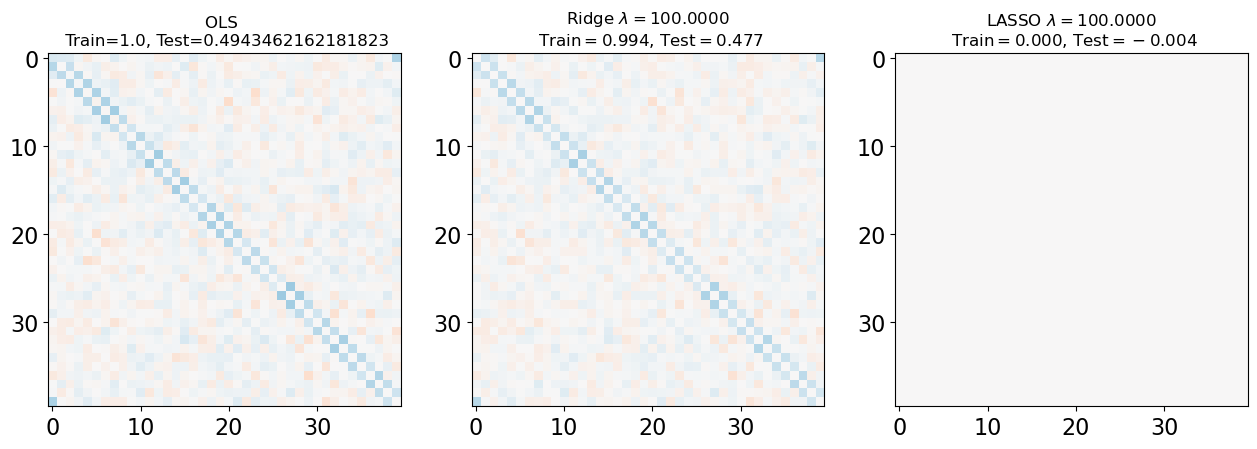

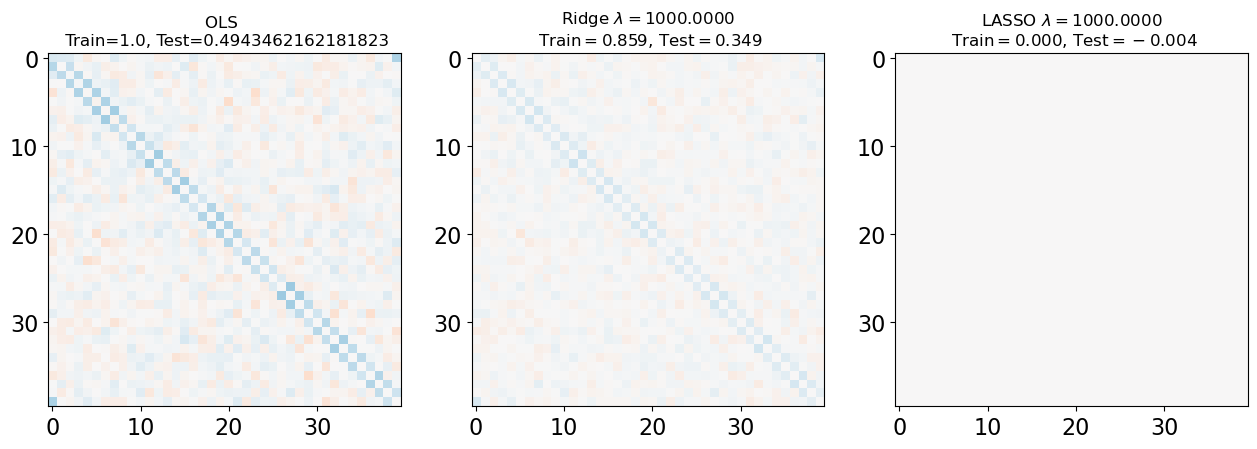

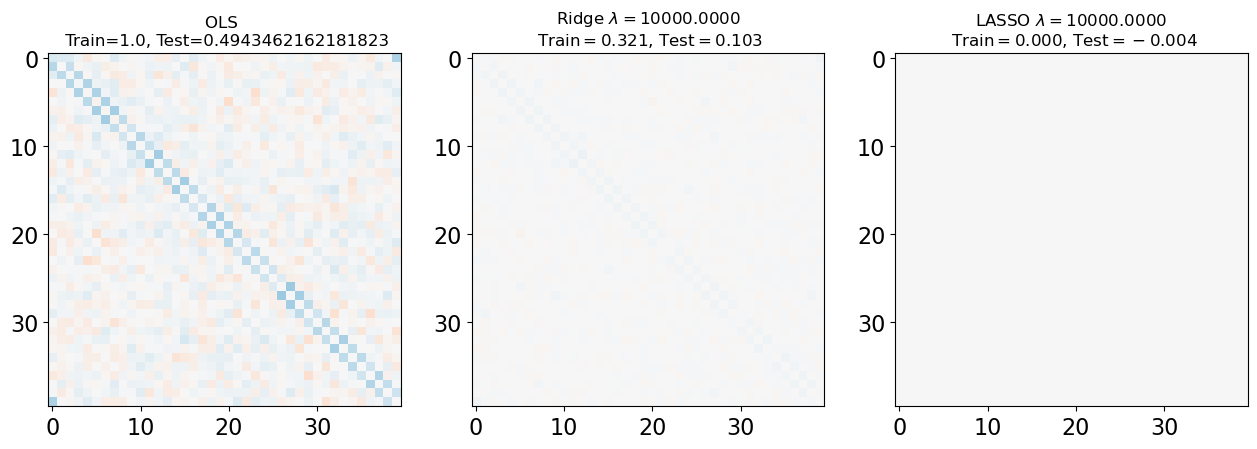

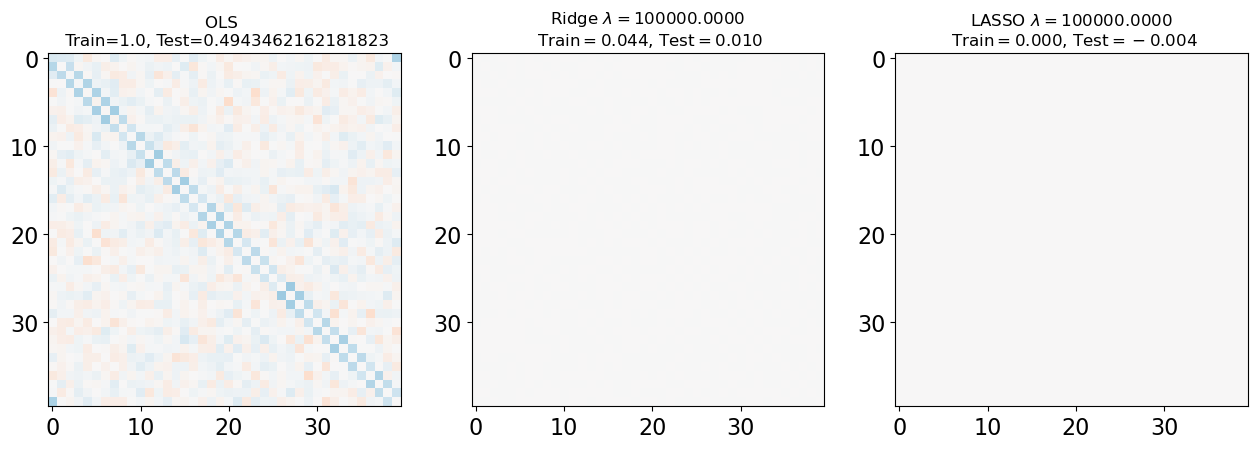

In [91]:


# Instantiate models
from sklearn import linear_model
model_ols = linear_model.LinearRegression()
model_l2 = linear_model.Ridge()
model_l1= linear_model.Lasso()

# Set regularization range
lambdas = np.logspace(-4, 5, 10)

# Load data
# define subset of samples
n_samples = 400
X_train, X_test = X_all[:n_samples], X_all[n_samples : 3 * n_samples // 2]
y_train, y_test = y_all[:n_samples], y_all[n_samples : 3 * n_samples // 2]

# define error lists
train_error_ols, test_error_ols = list(), list()
train_error_l2, test_error_l2 = list(), list()
train_error_l1, test_error_l1 = list(), list()

#Initialize coefficients for ridge regression and Lasso
coeffs_ols, coeffs_ridge, coeffs_lasso = list(), list(), list()

for lam in lambdas:
    ### ordinary least squares
    model_ols.fit(X_train, y_train) # fit model 
    coeffs_ols.append(model_ols.coef_) # store weights
    # use the coefficient of determination R^2 as the performance of prediction.
    train_error_ols.append(model_ols.score(X_train, y_train))
    test_error_ols.append(model_ols.score(X_test, y_test))

    ### ridge regression
    model_l2.set_params(alpha=lam) # set regularisation strength
    model_l2.fit(X_train, y_train) # fit model
    coeffs_ridge.append(model_l2.coef_) # store weights
    train_error_l2.append(model_l2.score(X_train, y_train))
    test_error_l2.append(model_l2.score(X_test, y_test))

    ### lasso
    model_l1.set_params(alpha=lam) # set regularisation strength
    model_l1.fit(X_train, y_train) # fit model
    coeffs_lasso.append(model_l1.coef_) # store weights
    train_error_l1.append(model_l1.score(X_train, y_train))
    test_error_l1.append(model_l1.score(X_test, y_test))




    ### plot Ising interaction J
    J_leastsq = np.array(model_ols.coef_).reshape((L, L))
    J_ridge = np.array(model_l2.coef_).reshape((L, L))
    J_lasso = np.array(model_l1.coef_).reshape((L, L))


    fig, axarr = plt.subplots(nrows=1, ncols=3)
    
    axarr[0].imshow(J_leastsq,  cmap="RdBu_r", vmin=-1, vmax=1)
    axarr[0].set_title(f"OLS \n Train={train_error_ols[-1]}, Test={test_error_ols[-1]}")
    ## 3 sig figs
    # axarr[0].set_title('OLS \n Train$=%.3f$, Test$=%.3f$' %(train_error_ols[-1],test_error_ols[-1]))
    axarr[1].set_title('OLS $\lambda=%.4f$\n Train$=%.3f$, Test$=%.3f$' %(lam, train_error_ols[-1],test_error_ols[-1]))
    axarr[0].tick_params(labelsize=16)
    
    axarr[1].imshow(J_ridge,  cmap="RdBu_r", vmin=-1, vmax=1)
    axarr[1].set_title('Ridge $\lambda=%.4f$\n Train$=%.3f$, Test$=%.3f$' %(lam, train_error_l2[-1],test_error_l2[-1]))
    axarr[1].tick_params(labelsize=16)
    
    im=axarr[2].imshow(J_lasso, cmap="RdBu_r", vmin=-1, vmax=1)
    axarr[2].set_title('LASSO $\lambda=%.4f$\n Train$=%.3f$, Test$=%.3f$' %(lam, train_error_l1[-1],test_error_l1[-1]))
    axarr[2].tick_params(labelsize=16)
    
    # divider = make_axes_locatable(axarr[2])
    # cax = divider.append_axes("right", size="5%", pad=0.05, add_to_figure=True)
    # cbar=fig.colorbar(im, cax=cax)
    
    # cbar.ax.set_yticklabels(np.arange(-1.0, 1.0+0.25, 0.25),fontsize=14)
    # cbar.set_label('$J_{i,j}$',labelpad=15, y=0.5,fontsize=20,rotation=0)
    
    fig.subplots_adjust(right=2.0)
    
    plt.show()

Text(0, 0.5, 'Performance $R^2$')

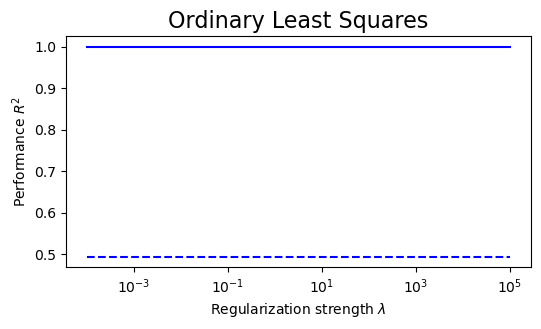

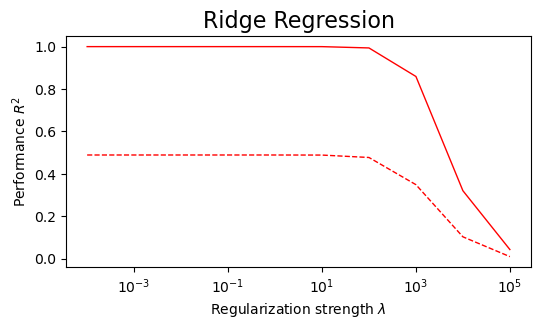

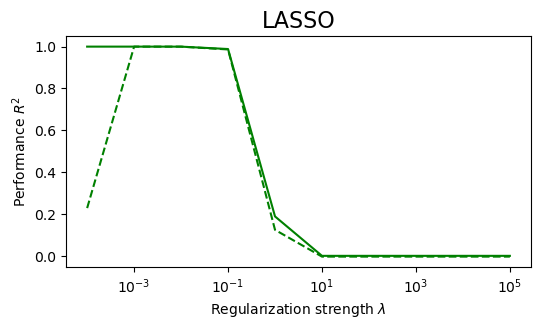

In [92]:
# Plot our performance on both the training and test data
plt.figure(figsize=(6, 3))
plt.semilogx(lambdas, train_error_ols, "b", label="Train (OLS)")
plt.semilogx(lambdas, test_error_ols, "--b", label="Test (OLS)")
plt.title("Ordinary Least Squares", fontsize=16)
plt.xlabel("Regularization strength $\lambda$")
plt.ylabel("Performance $R^2$")


plt.figure(figsize=(6, 3))
plt.semilogx(lambdas, train_error_l2, "r", label="Train (Ridge)", linewidth=1)
plt.semilogx(lambdas, test_error_l2, "--r", label="Test (Ridge)", linewidth=1)
plt.title("Ridge Regression", fontsize=16)
plt.xlabel("Regularization strength $\lambda$")
plt.ylabel("Performance $R^2$")

plt.figure(figsize=(6, 3))
plt.semilogx(lambdas, train_error_l1, "g", label="Train (LASSO)")
plt.semilogx(lambdas, test_error_l1, "--g", label="Test (LASSO)")
plt.title("LASSO", fontsize=16)
plt.xlabel("Regularization strength $\lambda$")
plt.ylabel("Performance $R^2$")


## Understanding our result

It looks like our coupling matrix is pretty sparse, and that the non-zero entries are concentrated along the off diagonal. This means that our Hamiltonian likely corresponds to the nearest-neighbor Ising model

$$
\mathcal{H}(\mathbf{s}^{(i)})=-J\sum_{j=1}^L s_{j}^{(i)}\, s_{j+1}^{(i)}
$$


+ When $\lambda\to 0$ and $\lambda\to\infty$, all three models overfit the data, as can be seen from the deviation of the test errors from unity (dashed lines), while the training curves stay at unity. 

+ While the ordinary least-squares and Ridge regression test curves are monotonic, the LASSO test curve is not -- suggesting the optimal LASSO regularization parameter is $\lambda\approx 10^{-2}$. At this sweet spot, the Ising interaction weights ${\bf J}$ contain only nearest-neighbor terms (as did the model the data was generated from).

+ Notice how Lasso was able to correctly identify that the coupling matrix is non-symmetric, while OLS and Ridge both favored finding symmetric matrices. 

# Hyperparameter tuning

We can imagine that an even more general model would have both regularizers, each with different strengths
$$
\mathcal{L}_{total} = \mathcal{L}_{least-squares} + \lambda_1 \mathcal{L}_{lasso} + \lambda_2 \mathcal{L}_{ridge}
$$
This loss function is sometimes referred to as least-squares with an ElasticNet penalty.


## Why not always use regularizers
+ The issue: we have two arbitrary factors, $\lambda_1$ and $\lambda_2$, which determine how important the L1 and L2 penalties are relative to the primary fitting. These change the available solution space and thus model class
+ These are not "fit" during training like ordinary parameters; rather they are specified beforehand, perhaps with a bit of intuition or domain knowledge, These therefore represent *hyperparameters* of the model
+ Generally speaking, any "choices" we make---amount of data, model type, model parameters, neural network depth, etc are all hyperparameters. How do we choose these in a principled manner?
+ A major question in machine learning: **How do we choose the best hyperparameters for a model?**



## Validation set
+ Hold out some data just for hyperparameter tuning, separate from the test set
+ Don't validate on test, that leads to data leakage and thus overfitting

Best lambda on validation set 0.0005336699231206307


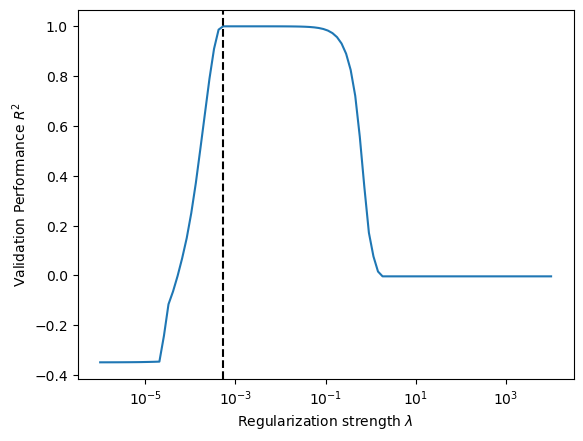

In [93]:
from sklearn import linear_model

# define train, validation and test data sets
X_train, X_val, X_test = X_all[:400], X_all[400 : 600], X_all[600 : 800]
y_train, y_val, y_test = y_all[:400], y_all[400 : 600], y_all[600 : 800]

# the hyperparameter values to check
lambdas = np.logspace(-6, 4, 100)

all_validation_losses = list()

for lam in lambdas:
    model_l1 = linear_model.Lasso(alpha=lam)
    model_l1.fit(X_train, y_train)
    validation_loss = model_l1.score(X_val, y_val)
    all_validation_losses.append(validation_loss)

best_lambda = lambdas[np.argmax(all_validation_losses)]

plt.semilogx(lambdas, all_validation_losses, label="Validation")
plt.axvline(best_lambda, color='k', linestyle='--', label="Best lambda")
plt.xlabel("Regularization strength $\lambda$")
plt.ylabel("Validation Performance $R^2$")

print("Best lambda on validation set", best_lambda)

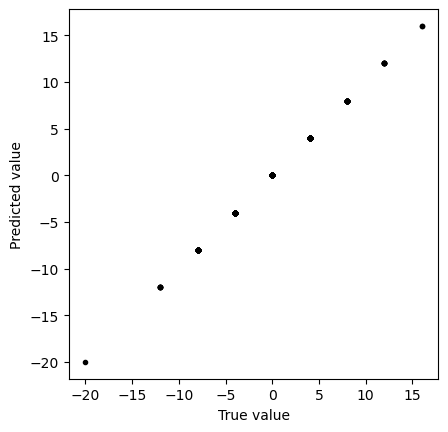

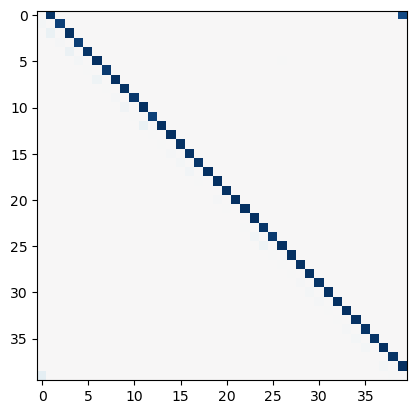

In [94]:
# fit best model 
model_l1 = linear_model.Lasso(alpha=best_lambda)
model_l1.fit(X_train, y_train)

y_test_predict = model_l1.predict(X_test)

plt.figure()
plt.plot(y_test, y_test_predict, ".k")
plt.xlabel("True value")
plt.ylabel("Predicted value")
plt.gca().set_aspect(1)


# plot Ising interaction J
J_lasso = np.array(model_l1.coef_).reshape((L, L))
plt.figure()
plt.imshow(J_lasso,  cmap="RdBu_r", vmin=-1, vmax=1)
plt.gca().set_aspect(1)

## Cross-validation

+ We repeatedly split-up the train into multiple sub-splits for training and validation
+ For example, if we have 100 train points, we can create five 80:20 "splits", and average the best hyperparameter across the splits
+ If we perform $k$ subsplits, we refer to our procedure as k-fold cross-validation
+ More elaborate splitting methods (random Monte Carlo, importance weighted, etc)


<img src="../resources/cross_val.png" alt="supervised_learning" style="width: 750px;"/>

Image from [source](https://towardsdatascience.com/cross-validation-k-fold-vs-monte-carlo-e54df2fc179b)

Best lambda on validation set 0.005623413251903491


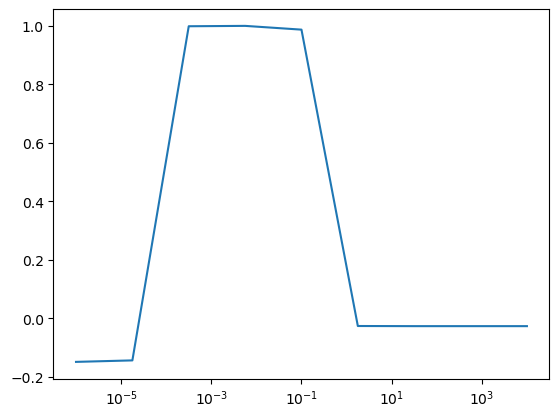

In [96]:
## Cross validation

from sklearn import linear_model

# define train, validation and test data sets
X_train, X_test = X_all[:600], X_all[600 : 800]
y_train, y_test = y_all[:600], y_all[600 : 800]

# the hyperparameter values to check
lambdas = np.logspace(-6, 4, 9)

all_validation_losses = list()

for lam in lambdas:

    all_val_loss_lam = list()

    for k in range(5):

        # Create the training and validation subsets from the training data
        X_train_k = np.concatenate([X_train[:k*100], X_train[(k+1)*100:]])
        y_train_k = np.concatenate([y_train[:k*100], y_train[(k+1)*100:]])
        X_val_k = X_train[k*100:(k+1)*100]
        y_val_k = y_train[k*100:(k+1)*100]


        model_l1 = linear_model.Lasso(alpha=lam)
        model_l1.fit(X_train_k, y_train_k)
        validation_loss = model_l1.score(X_val_k, y_val_k)
        all_val_loss_lam.append(validation_loss)

    all_validation_losses.append(np.mean(all_val_loss_lam))

best_lambda = lambdas[np.argmax(all_validation_losses)]
plt.figure()
plt.semilogx(lambdas, all_validation_losses, label="Validation")
print("Best lambda on validation set", best_lambda)

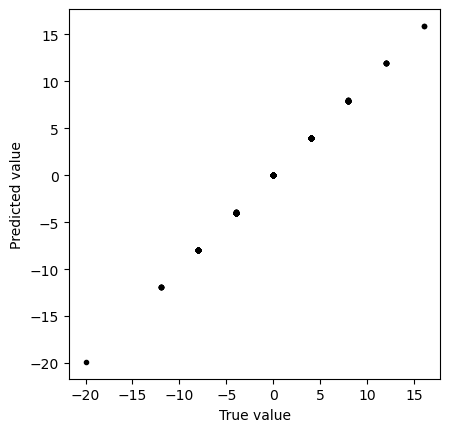

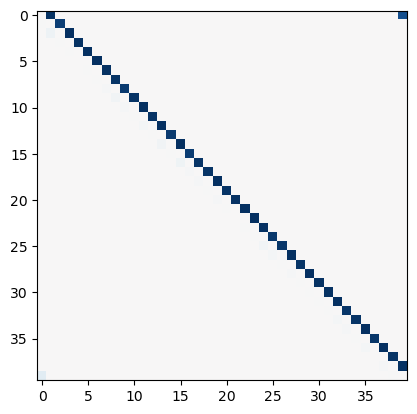

In [97]:
# fit best model 
model_l1 = linear_model.Lasso(alpha=best_lambda)
model_l1.fit(X_train, y_train)

y_test_predict = model_l1.predict(X_test)

plt.figure()
plt.plot(y_test, y_test_predict, ".k")
plt.xlabel("True value")
plt.ylabel("Predicted value")
plt.gca().set_aspect(1)


# plot Ising interaction J
J_lasso = np.array(model_l1.coef_).reshape((L, L))
plt.figure()
plt.imshow(J_lasso,  cmap="RdBu_r", vmin=-1, vmax=1)
plt.gca().set_aspect(1)

## How many free parameters are in our model?

Linear regression:

$$
y_i = \mathbf{A} \mathbf{X}_i
$$

+ In our Ising example, the fitting parameters $\mathbf{A}$ corresponded to our coupling matrix $\mathbf{J}$
+ $\mathbf{X}_i$ were our spin product microstates, and $y_i$ was their energies
+ $\mathbf{J} \in \mathbb{R}^{40 \times 40}$ because our inputs (microstates) are on an $L = 40$ lattice, and so we had $1600$ free parameters


## What if we wanted to increase our model complexity?

### Idea: 

$$
y_i = \mathbf{B} \mathbf{C} \mathbf{X}_i
$$

where $\mathbf{B} \in \mathbb{R}^{40 \times p}$ and $\mathbf{C} \in \mathbb{R}^{p \times 40}$, with $p$ being a hyperparameter that controls the complexity of the model. This "hidden" or "latent" dimensionality allows us to have a more complex model.

However, the problem is that $\mathbf{B} \mathbf{C} \equiv \mathbf{A}\in \mathbb{R}^{40 \times 40}$, so we don't gain any expressivity

### Solution:

$$
y_i = \mathbf{B} \sigma(\mathbf{C} \mathbf{X}_i)
$$

where $\sigma(.)$ is an elementwise nonlinear function, like $\tanh(.)$. Now the model doesn't collapse, so we have $2 \times 40 \times p$ free parameters.

This is a one-layer neural network, with a $p$ unit "hidden" layer. We can always go wider or deeper to further increase the model complexity.

# Appendix

Simulate the Ising model with nearest-neighbor interactions with periodic boundary conditions. The energy of a spin configuration $\boldsymbol{\sigma} = \{\sigma_1,\dots,\sigma_N\}$ is given by

$$
E[\boldsymbol{\sigma}] = -J\sum_{\langle i,j\rangle} \sigma_i \sigma_j
$$

where the sum is over all pairs of nearest neighbors on a $L\times L$ square lattice, and $J$ is the coupling constant. The magnetization is given by

$$
M[\boldsymbol{\sigma}] = \sum_{i=1}^N \sigma_i
$$

In [ ]:
class IsingModel:
    """
    The Ising model with ferromagnetic interactions that encourage nearest neighbors
    to align
    """
    def __init__(self, L, random_state=None):
        self.L = L
        self.random_state = random_state
        
        self.J = np.diag(-np.ones(L - 1), 1)
        self.J [-1, 0] = -1.0 # periodic boundary conditions

    def sample(self, n_samples=1):
        if self.random_state is not None:
            np.random.seed(self.random_state)
        return np.random.choice([-1, 1], size=(n_samples, self.L))

    def energy(self, state):
        return np.einsum("...i,ij,...j->...", states, self.J, states)

model_experiment = IsingModel(40, random_state=0)

# create 10000 random Ising states
states = model_experiment.sample(n_samples=10000)


# calculate Ising energies
energies = model_experiment.energy(states)

print("Input data has shape: ", states.shape)
print("Labels have shape: ", energies.shape)


## Save data
# states.dump("../resources/spin_microstates.npy")
# energies.dump("../resources/spin_energies.npy")